# Imports


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
from google.colab import drive

import os
import random
import zipfile
import math
import time
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
from  matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.functional as F

# Constants



In [ ]:
my_drive = "My Drive"
mount_drive = "/content/drive"

# datasets folders
dataset_folder = "Dataset_LRRO"
lab_dataset_folder = "Lab_LRRo_data_set"
wild_dataset_folder = "Wild_LRRo_data_set"

# folder where models will be saved
general_path = "Licenta"
model_params_path = "Models"
graphs_params_path = "Graphs"
datasets_params_path = "Datasets"
if not os.path.exists(model_params_path):
  os.mkdir(model_params_path)

train_folder = "train"
val_folder = "val"
test_folder = "test"

# video constants
IMAGE_WIDTH = 88
IMAGE_HEIGHT = 88
NUMBER_FRAMES = 29

dataset_used = "wild"

# Extracting the dataset

In [ ]:
# loading the dataset from Google Drive
drive.mount(mount_drive)

dataset_zip = dataset_folder + ".zip"
zipfile_path = os.path.join(mount_drive, my_drive, dataset_zip)
with zipfile.ZipFile(zipfile_path, "r") as zip_ref:
  zip_ref.extractall(".")

Mounted at /content/drive


# Loading the dataset



In [ ]:
# paths to the datasets
my_drive_path = os.path.join(mount_drive, my_drive)
lab_dataset_path = os.path.join(dataset_folder, lab_dataset_folder)
wild_dataset_path = os.path.join(dataset_folder, wild_dataset_folder)

# get dictionary mapping label string to an integer
def get_label_dict(path):
  d = {}
  l = []

  # folder names in the training set folder are the labels
  folder = os.path.join(path, train_folder)
  for ground_truth in os.listdir(folder):
    l.append(ground_truth)

  # create the dict
  d = dict([(y, x) for x, y in enumerate(sorted(set(l)))])
  return d

# reading one split set from a folder (can be either train, validation or test set)
def read_split_set(path, d):
  split_set_x = []
  split_set_y = []

  # each subfolder name is the ground truth of the video
  for ground_truth in os.listdir(path):
    word_path = os.path.join(path, ground_truth)

    # each further subfolder contains a video of a speaker uttering a word
    # the subolder name is the speaker ID
    for speaker_id in os.listdir(word_path):
      video = []
      video_path = os.path.join(word_path, speaker_id)
      for image_id in range(NUMBER_FRAMES):
        image_id = str(image_id) + ".jpg"
        image_path = os.path.join(video_path, image_id)

        # read the image using OpenCV and add it to the video
        image = cv2.imread(image_path, 0)
        image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation = cv2.INTER_AREA)
        image = np.array(image)

        # normalize the image
        image = image.astype('float32')
        image /= 255.0
        video.append(image)

      # add video and ground truth to the dataset
      video_np = np.array(video)
      split_set_x.append(video_np)
      split_set_y.append(d[ground_truth])

  # create the numpy arrays with the suitable shapes
  return split_set_x, split_set_y

# reading the train, validation and test set from a folder
def read_dataset(path, d):
  train_set_path = os.path.join(path, train_folder)
  val_set_path = os.path.join(path, val_folder)
  test_set_path = os.path.join(path, test_folder)

  train_set = read_split_set(train_set_path, d)
  val_set = read_split_set(val_set_path, d)
  test_set = read_split_set(test_set_path, d)

  return train_set, val_set, test_set

In [ ]:
class VideoDataset(Dataset):
  def __init__(self, video_list, label_list, transforms=None):
    self.video_list = video_list
    self.label_list = label_list
    self.transforms=transforms

  def __len__(self):
    return len(self.video_list)

  def __getitem__(self, i):
    video = self.video_list[i]

    if self.transforms is not None:
      video = self.transforms(video)

    video = np.asarray(video).reshape(NUMBER_FRAMES, 1, IMAGE_WIDTH, IMAGE_HEIGHT)
    video = torch.tensor(video, dtype=torch.float)
    return video, self.label_list[i]

In [ ]:
class HorizontalFlip(object):
    """Flip image horizontally.
    """
    def __init__(self, flip_ratio):
        self.flip_ratio = flip_ratio

    def __call__(self, frames):
        """
        Args:
            img (numpy.ndarray): Images to be flipped with a probability flip_ratio
        Returns:
            numpy.ndarray: Flipped images.
        """
        f, h, w = frames.shape
        if random.random() < self.flip_ratio:
            for index in range(f):
                frames[index] = cv2.flip(frames[index], 1)
        return frames

In [ ]:
label_dict_wild = get_label_dict(wild_dataset_path)
print(label_dict_wild)

label_dict_lab = get_label_dict(lab_dataset_path)
print(label_dict_lab)

{'aceasta': 0, 'bucuresti': 1, 'cincizeci': 2, 'distractor': 3, 'douazeci': 4, 'dumneavoastra': 5, 'inainte': 6, 'inceput': 7, 'informatii': 8, 'inseamna': 9, 'intr-un': 10, 'lucrurile': 11, 'milioane': 12, 'momentul': 13, 'niciodata': 14, 'probabil': 15, 'problema': 16, 'referendum': 17, 'romana': 18, 'romania': 19, 'scoala': 20}
{'analizat': 0, 'ancheta': 1, 'apararea': 2, 'aruncare': 3, 'camerele': 4, 'ciuperca': 5, 'comisia': 6, 'comision': 7, 'cuvinte': 8, 'directioneaza': 9, 'dispozitiv': 10, 'distractor': 11, 'doare': 12, 'electrica': 13, 'europa': 14, 'exagerat': 15, 'externa': 16, 'filmeaza': 17, 'grupare': 18, 'grupeaza': 19, 'improvizat': 20, 'improvizeaza': 21, 'impusca': 22, 'incendiu': 23, 'intalnire': 24, 'jandarmi': 25, 'limita': 26, 'lovesc': 27, 'lovitura': 28, 'masina': 29, 'multimea': 30, 'pachetul': 31, 'perioada': 32, 'pietre': 33, 'politia': 34, 'privat': 35, 'prost': 36, 'protectie': 37, 'protest': 38, 'protesteaza': 39, 'puterea': 40, 'securitate': 41, 'siguran

In [ ]:
# datasets shapes
def print_dataset_shapes(X, y):
  print(np.asarray(X).shape)
  print(np.asarray(y).shape)

def split_sets(train_set, val_set, test_set):
  train_set_x, train_set_y = train_set
  val_set_x, val_set_y = val_set
  test_set_x, test_set_y = test_set

  print_dataset_shapes(train_set_x, train_set_y)
  print_dataset_shapes(val_set_x, val_set_y)
  print_dataset_shapes(test_set_x, test_set_y)

  # train_set_x = train_set_x[:2]
  # train_set_y = train_set_y[:2]
  # test_set_x = test_set_x[:2]
  # test_set_y = test_set_y[:2]
  # val_set_x = val_set_x[:2]
  # val_set_y = val_set_y[:2]

  print()
  print_dataset_shapes(train_set_x, train_set_y)
  print_dataset_shapes(val_set_x, val_set_y)
  print_dataset_shapes(test_set_x, test_set_y)

  return train_set_x, train_set_y, val_set_x, val_set_y, test_set_x, test_set_y

In [ ]:
# reading the Wild or Lab LRRo Dataset
if dataset_used == "wild":
  train_set, val_set, test_set = read_dataset(wild_dataset_path, label_dict_wild)
else:
  train_set, val_set, test_set = read_dataset(lab_dataset_path, label_dict_lab)

# get datasets x and y
train_set_x, train_set_y, val_set_x, val_set_y, test_set_x, test_set_y = split_sets(train_set, val_set, test_set)

(848, 29, 88, 88)
(848,)
(120, 29, 88, 88)
(120,)
(121, 29, 88, 88)
(121,)

(848, 29, 88, 88)
(848,)
(120, 29, 88, 88)
(120,)
(121, 29, 88, 88)
(121,)


# Lip Reading Model


## Model Constants


### Basic Models

In [ ]:
#-----------------------------#
lab_lrro_number_classes = 48
wild_lrro_number_classes = 21

"""
lr: learning rate
use_dropblock: use DropBlock as Convolutional Dropout
se: use Squeeze and Excitation blocks
separable_conv: use Depthwise Separable Convolutions or not
use_tcn: use Temporal Convolutional Networks as frontend
tcn_options: hyperparameters for the TCN
"""

params_resnet_gru = {
    "num_epochs": 80,
    "batch_size": 32,
    "num_workers": 2,
    "num_classes": wild_lrro_number_classes,
    "lr": 3e-4,
    "drop_prob": 0.12,
    "use_dropblock": True,
    "mixup": True,
    "se": True,
    "separable_conv": False,
    "backbone_type": "resnet",
    "use_tcn": False,
    "use_adam": True,
    "tcn_options": {},
    "model_filename": "best_model_resnet18_gru_wild.pth",
    "model_graphs_folder": "ResnetGRU"
}

params_resnet_gru_nodropblock = {
    "num_epochs": 80,
    "batch_size": 32,
    "num_workers": 2,
    "num_classes": wild_lrro_number_classes,
    "lr": 3e-4,
    "drop_prob": 0.12,
    "use_dropblock": False,
    "mixup": True,
    "se": True,
    "separable_conv": False,
    "backbone_type": "resnet",
    "use_tcn": False,
    "use_adam": True,
    "tcn_options": {},
    "model_filename": "best_model_resnet18_gru_nodrop.pth",
    "model_graphs_folder": "ResnetGRU_nodrop"
}

params_resnet_mstcn = {
    "num_epochs": 80,
    "batch_size": 32,
    "num_workers": 2,
    "num_classes": wild_lrro_number_classes,
    "lr": 3e-4,
    "drop_prob": 0.12,
    "use_dropblock": True,
    "mixup": True,
    "se": True,
    "separable_conv": False,
    "backbone_type": "resnet",
    "use_tcn": True,
    "use_adam": True,
    "tcn_options": {
        "dropout": 0.1,
        "separable_conv": False,
        "kernel_size": [3, 5, 7],
        "num_layers": 4,
        "width_mult": 1
    },
    "model_filename": "best_model_resnet18_mstcn.pth",
    "model_graphs_folder": "ResnetMSTCN"
}

params_resnet_mstcn_nodropblock = {
    "num_epochs": 80,
    "batch_size": 32,
    "num_workers": 2,
    "num_classes": wild_lrro_number_classes,
    "lr": 3e-4,
    "drop_prob": 0.12,
    "use_dropblock": False,
    "mixup": True,
    "se": True,
    "separable_conv": False,
    "backbone_type": "resnet",
    "use_tcn": True,
    "use_adam": True,
    "tcn_options": {
        "dropout": 0.1,
        "separable_conv": False,
        "kernel_size": [3, 5, 7],
        "num_layers": 4,
        "width_mult": 1
    },
    "model_filename": "best_model_resnet18_mstcn_nodropblock.pth",
    "model_graphs_folder": "ResnetMSTCN_nodrop"
}

params_mobilenet_ds_mstcn_1 = {
    "num_epochs": 80,
    "batch_size": 32,
    "num_workers": 2,
    "num_classes": wild_lrro_number_classes,
    "lr": 3e-4,
    "drop_prob": 0.12,
    "use_dropblock": True,
    "mixup": True,
    "se": True,
    "separable_conv": False,
    "backbone_type": "mobilenet",
    "use_tcn": True,
    "use_adam": True,
    "tcn_options": {
        "dropout": 0.2,
        "separable_conv": True,
        "kernel_size": [3, 5, 7],
        "num_layers": 4,
        "width_mult": 1
    },
    "model_filename": "best_model_mobilenet_ds_mstcn.pth"
}

params_mobilenet_ds_mstcn_05 = {
    "num_epochs": 80,
    "batch_size": 32,
    "num_workers": 2,
    "num_classes": wild_lrro_number_classes,
    "lr": 3e-4,
    "drop_prob": 0.12,
    "use_dropblock": True,
    "mixup": True,
    "se": True,
    "separable_conv": False,
    "backbone_type": "mobilenet",
    "use_tcn": True,
    "use_adam": True,
    "tcn_options": {
        "dropout": 0.2,
        "separable_conv": True,
        "kernel_size": [3, 5, 7],
        "num_layers": 4,
        "width_mult": 1
    },
    "width_mult": 0.5,
    "model_filename": "best_model_mobilenet_ds_mstcn.pth"
}

params_mobilenet_tcn = {
    "num_epochs": 160,
    "batch_size": 32,
    "num_workers": 2,
    "num_classes": wild_lrro_number_classes,
    "lr": 3e-4,
    "drop_prob": 0.12,
    "use_dropblock": True,
    "mixup": True,
    "se": True,
    "separable_conv": False,
    "backbone_type": "mobilenet",
    "use_tcn": True,
    "use_adam": True,
    "tcn_options": {
        "dropout": 0.2,
        "separable_conv": True,
        "kernel_size": [5],
        "num_layers": 4,
        "width_mult": 1
    },
    "model_filename": "best_model_mobilenet_tcn.pth"
}

### Lateral Inhibition

In [ ]:
params_resnet_mstcn_li = {
    "num_epochs": 80,
    "batch_size": 32,
    "num_workers": 2,
    "num_classes": wild_lrro_number_classes,
    "lr": 3e-4,
    "drop_prob": 0.12,
    "use_dropblock": True,
    "mixup": True,
    "se": True,
    "separable_conv": False,
    "backbone_type": "resnet",
    "use_tcn": True,
    "use_adam": True,
    "tcn_options": {
        "dropout": 0.1,
        "separable_conv": False,
        "kernel_size": [3, 5, 7],
        "num_layers": 4,
        "width_mult": 1
    },
    "model_filename": "best_model_resnet18_mstcn_li.pth",
    "model_graphs_folder": "ResnetMSTCN_LI",
    "use_li": True
}

params_resnet_gru_li = {
    "num_epochs": 80,
    "batch_size": 32,
    "num_workers": 2,
    "num_classes": wild_lrro_number_classes,
    "lr": 3e-4,
    "drop_prob": 0.12,
    "use_dropblock": True,
    "mixup": True,
    "se": True,
    "separable_conv": False,
    "backbone_type": "resnet",
    "use_tcn": False,
    "use_adam": True,
    "tcn_options": {},
    "model_filename": "best_model_resnet18_gru_li.pth",
    "model_graphs_folder": "ResnetGRU_LI",
    "use_li": True
}

## DropBlock

### Basic block

In [ ]:
# basic DropBlock module used to replace dropout in 2D Convolutions
class DropBlock(nn.Module):
    def __init__(self, drop_prob = 0.1, block_size = 7):
        super(DropBlock, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)

### Block with Linear Scheduling

In [ ]:
class LinearScheduler(nn.Module):
    def __init__(self, dropblock, start_value, stop_value, nr_steps):
        super(LinearScheduler, self).__init__()
        self.dropblock = dropblock
        self.i = 0
        self.drop_values = np.linspace(start=start_value, stop=stop_value, num=int(nr_steps))

    def forward(self, x):
        return self.dropblock(x)

    def step(self):
        if self.i < len(self.drop_values):
            self.dropblock.keep_prob = 1 - self.drop_values[self.i]

        self.i += 1

## Lateral Inhibition

In [ ]:
class LateralInhibition(nn.Module):
    def __init__(self, num,sigma):
        super().__init__()

        self.sigma=sigma
        ApproxHeaviside.sigma=sigma

        self.num_units=num
        myw=torch.empty(num,num)
        nn.init.normal_(myw,std=0.02)
        self.w = nn.Parameter(myw)
        self.b = nn.Parameter(torch.zeros(num))

        #self.relu=nn.ReLU()

        #print("BUILD:")
        #print("   w=",self.w)
        #print("   b=",self.b)
        #print(self.zerodiag)
        #exit(-1)

    def forward(self, inputs):
        #print("CALL:")
        #print(inputs)
        #print("reshape")
        shape=list(inputs.size())
        rinputs=torch.reshape(inputs,(shape[0]*shape[1],1,self.num_units))
        #print("   rinputs=",rinputs)

        w1=self.w.clone()
        w1=w1.fill_diagonal_(0)
        #w1=self.w # aici e gresit => tb prin get diag => neg => add


        #logger.info("   w1=",w1)

        #w1=tf.linalg.set_diag(self.w, self.zerodiag)
        inhib=torch.matmul(rinputs,w1) # aici tb w1
        #print("   inhib=",inhib)

        #print("   rinputs.size=",rinputs.shape)
        #print("   w1.size=",w1.shape)
        #print("   inhib.size=",inhib.shape)



        inhib=inhib+self.b
        #print("   inhib+b=",inhib)
        #inhib=self.relu(inhib)
        inhib=ApproxHeaviside.apply(inhib) #,self.values)

        #print("   inhib(relu)=",inhib)
        inhib=torch.reshape(inhib,[shape[0]*shape[1],self.num_units])
        #print("   inhib=",inhib)
        w_inhib=torch.diag_embed(inhib)
        #print("   w_inhib=",w_inhib)
        r=torch.matmul(rinputs, w_inhib)
        #print("   r=",r)
        #r=torch.reshape(r,[shape[0],self.num_units])
        r=torch.reshape(r,shape)
        #logger.info("   r(reshape)=",r)
        #exit(-1)
        return r

## Visual frontend

### Regular convolutions

In [ ]:
# 3x3 kernel convolution
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

# 1x1 kernel convolution
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1)

### Depthwise separable convolutions

In [ ]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(
            in_planes,
            in_planes,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_planes,
            bias=bias
        )
        self.pointwise = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [ ]:
# 3x3 depthwise separable convolution
def conv3x3_separable(in_planes, out_planes, stride = 1):
  return DepthwiseSeparableConv(
      in_planes=in_planes,
      out_planes=out_planes,
      kernel_size=3,
      stride=stride,
      padding=1,
      bias=False
  )

### ResNet-18

In [ ]:
# basic Squeeze and Excitation block for the ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, use_dropblock=False, stride=1,
                 downsample=None, drop_prob=0.1, se=False, separable_conv=False):
        super(BasicBlock, self).__init__()
        self.separable_conv = separable_conv
        self.use_dropblock = use_dropblock

        if self.separable_conv:
          self.conv1 = conv3x3_separable(inplanes, planes, stride)
          self.conv2 = conv3x3_separable(planes, planes)
        else:
          self.conv1 = conv3x3(inplanes, planes, stride)
          self.conv2 = conv3x3(planes, planes)

        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace = True)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride
        self.se = se

        self.dropblock = LinearScheduler(
          DropBlock(),
          start_value=0,
          stop_value=drop_prob,
          nr_steps = 5e3
        )

        if(self.se):
            self.gap = nn.AdaptiveAvgPool2d(1)
            self.conv3 = conv1x1(planes, planes//16)
            self.conv4 = conv1x1(planes//16, planes)

    def forward(self, x):
        if self.use_dropblock:
          self.dropblock.step()

        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        if self.use_dropblock:
          out = self.dropblock(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_dropblock:
          out = self.dropblock(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if(self.se):
            w = self.gap(out)
            w = self.conv3(w)
            w = self.relu(w)
            w = self.conv4(w).sigmoid()

            out = out * w

        out = out + residual
        out = self.relu(out)

        return out

In [ ]:
# ResNet18 Implementation
class ResNet(nn.Module):
    def __init__(self, block, layers, drop_prob=0.1, se=False, use_dropblock=False,
                 separable_conv=False):
      super(ResNet, self).__init__()

      self.inplanes = 64
      self.se = se
      self.drop_prob = drop_prob
      self.use_dropblock = use_dropblock
      self.separable_conv = separable_conv

      self.layer1 = self._make_layer(block, 64, layers[0])
      self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
      self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
      self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

      self.avgpool = nn.AdaptiveAvgPool2d(1)

      self.bn = nn.BatchNorm1d(512)

      # layer initializations
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
              m.weight.data.normal_(0, math.sqrt(2. / n))
          elif isinstance(m, nn.BatchNorm2d):
              m.weight.data.fill_(1)
              m.bias.data.zero_()
          elif isinstance(m, nn.BatchNorm1d):
              m.weight.data.fill_(1)
              m.bias.data.zero_()

    # create layer in the ResNet network
    def _make_layer(self, block, planes, number_blocks, stride=1):
      downsample = None
      if stride != 1 or self.inplanes != planes * block.expansion:
          downsample = nn.Sequential(
              nn.Conv2d(self.inplanes, planes * block.expansion,
                        kernel_size=1, stride=stride, bias=False),
              nn.BatchNorm2d(planes * block.expansion),
          )

      layers = []
      layers.append(block(self.inplanes, planes, stride=stride, downsample=downsample,
                          drop_prob=self.drop_prob, se=self.se,
                          use_dropblock=self.use_dropblock, separable_conv=self.separable_conv))
      self.inplanes = planes * block.expansion
      for i in range(1, number_blocks):
          layers.append(block(self.inplanes, planes, se=self.se))

      return nn.Sequential(*layers)

    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)

      x = self.avgpool(x)
      x = x.view(x.size(0), -1)
      x = self.bn(x)
      return x

## MobileNetV2

### Inverted Residual

In [ ]:
def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

In [ ]:
class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.identity = stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)

### Model

In [ ]:
class ApproxHeaviside(torch.autograd.Function):
    # Activation function with surrogate gradient
    sigma = 10.0

    @staticmethod
    def forward(ctx, input):
        output = torch.zeros_like(input)
        output[input > 0] = 1.0
        ctx.save_for_backward(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # approximation of the gradient using sigmoid function
        grad = grad_input * torch.sigmoid(ApproxHeaviside.sigma * input) * torch.sigmoid(
            -ApproxHeaviside.sigma * input)
        return

In [ ]:
class LateralInhibition(nn.Module):
    def __init__(self, num,sigma):
        super().__init__()

        self.sigma=sigma
        ApproxHeaviside.sigma=sigma

        self.num_units=num
        myw=torch.empty(num,num)
        nn.init.normal_(myw,std=0.02)
        self.w = nn.Parameter(myw)
        self.b = nn.Parameter(torch.zeros(num))
        #self.relu=nn.ReLU()

        #print("BUILD:")
        #print("   w=",self.w)
        #print("   b=",self.b)
        #print(self.zerodiag)
        #exit(-1)

    def forward(self, inputs):
        #print("CALL:")
        #print(inputs)
        #print("reshape")
        shape=list(inputs.size())
        #print(shape)
        rinputs=torch.reshape(inputs,(shape[0]*shape[1],1,self.num_units))
        #print("   rinputs=",rinputs)

        w1=self.w.clone()
        w1=w1.fill_diagonal_(0)
        #w1=self.w # aici e gresit => tb prin get diag => neg => add


        #logger.info("   w1=",w1)

        #w1=tf.linalg.set_diag(self.w, self.zerodiag)
        inhib=torch.matmul(rinputs,w1) # aici tb w1
        #print("   inhib=",inhib)

        #print("   rinputs.size=",rinputs.shape)
        #print("   w1.size=",w1.shape)
        #print("   inhib.size=",inhib.shape)



        inhib=inhib+self.b
        #print("   inhib+b=",inhib)
        #inhib=self.relu(inhib)
        inhib=ApproxHeaviside.apply(inhib) #,self.values)

        #print("   inhib(relu)=",inhib)
        inhib=torch.reshape(inhib,[shape[0]*shape[1],self.num_units])
        #print("   inhib=",inhib)
        w_inhib=torch.diag_embed(inhib)
        #print("   w_inhib=",w_inhib)
        r=torch.matmul(rinputs, w_inhib)
        #print("   r=",r)
        #r=torch.reshape(r,[shape[0],self.num_units])
        r=torch.reshape(r,shape)
        #logger.info("   r(reshape)=",r)
        #exit(-1)
        return r

In [ ]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000, width_mult=1.):
        super(MobileNetV2, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = [
            # t, c, n, s
            [1,  16, 1, 1],
            [6,  24, 2, 2],
            [6,  32, 3, 2],
            [6,  64, 4, 2],
            [6,  96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        input_channel = _make_divisible(32 * width_mult, 4 if width_mult == 0.1 else 8)
        layers = [conv_3x3_bn(24, input_channel, 2)]
        # building inverted residual blocks
        block = InvertedResidual
        for t, c, n, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 4 if width_mult == 0.1 else 8)
            for i in range(n):
                layers.append(block(input_channel, output_channel, s if i == 0 else 1, t))
                input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        output_channel = _make_divisible(1280 * width_mult, 4 if width_mult == 0.1 else 8) if width_mult > 1.0 else 1280
        self.conv = conv_1x1_bn(input_channel, output_channel)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # lateral inhibition layer
        self.li = LateralInhibition(output_channel, 10)
        self.classifier = nn.Linear(output_channel, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        # lateral inhibition forward
        x = self.li(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

## Temporal Convolution

### Chomp

In [ ]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size, symm_chomp):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size
        self.symm_chomp = symm_chomp
        if self.symm_chomp:
            assert self.chomp_size % 2 == 0, "If symmetric chomp, chomp size needs to be even"

    def forward(self, x):
        if self.chomp_size == 0:
            return x
        if self.symm_chomp:
            return x[:, :, self.chomp_size//2:-self.chomp_size//2].contiguous()
        else:
            return x[:, :, :-self.chomp_size].contiguous()

class ConvBatchChompRelu(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, separable_conv=False):
        super(ConvBatchChompRelu, self).__init__()
        self.separable_conv = separable_conv
        if separable_conv:
            self.conv = nn.Sequential(
                # depthwise convoluion
                nn.Conv1d(n_inputs, n_inputs, kernel_size, stride=stride,
                           padding=padding, dilation=dilation, groups=n_inputs, bias=False),
                nn.BatchNorm1d(n_inputs),
                Chomp1d(padding, True),
                nn.ReLU(inplace=True),
                # pointwise convolution
                nn.Conv1d( n_inputs, n_outputs, 1, 1, 0, bias=False),
                nn.BatchNorm1d(n_outputs),
                nn.ReLU(inplace=True)
            )
        else:
            self.conv = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
            self.batchnorm = nn.BatchNorm1d(n_outputs)
            self.chomp = Chomp1d(padding,True)
            self.non_lin = nn.ReLU()

    def forward(self, x):
        if self.separable_conv:
            return self.conv(x)
        else:
            out = self.conv(x)
            out = self.batchnorm(out)
            out = self.chomp(out)
            return self.non_lin(out)

### Standard Temporal Convolutional Network

In [ ]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2,
                 symm_chomp = False, separable_conv=False):
        super(TemporalBlock, self).__init__()

        if separable_conv:
            self.net = nn.Sequential(
                # first conv set
                # depthwise convolution
                nn.Conv1d(n_inputs, n_inputs, kernel_size, stride=stride,
                           padding=padding, dilation=dilation, groups=n_inputs, bias=False),
                nn.BatchNorm1d(n_inputs),
                Chomp1d(padding, True),
                nn.ReLU(inplace=True),
                # pointwise convolution
                nn.Conv1d(n_inputs, n_outputs, 1, 1, 0, bias=False),
                nn.BatchNorm1d(n_outputs),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout),

                # second conv set
                # depthwise convolution
                nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride,
                           padding=padding, dilation=dilation, groups=n_outputs, bias=False),
                nn.BatchNorm1d(n_outputs),
                Chomp1d(padding, True),
                nn.ReLU(inplace=True),
                # pointwise convolution
                nn.Conv1d(n_outputs, n_outputs, 1, 1, 0, bias=False),
                nn.BatchNorm1d(n_outputs),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout)
            )
        else:
            self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                   stride=stride, padding=padding, dilation=dilation)
            self.batchnorm1 = nn.BatchNorm1d(n_outputs)
            self.chomp1 = Chomp1d(padding, symm_chomp)  if not self.no_padding else None
            self.relu1 = nn.ReLU()
            self.dropout1 = nn.Dropout(dropout)

            self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                   stride=stride, padding=padding, dilation=dilation)
            self.batchnorm2 = nn.BatchNorm1d(n_outputs)
            self.chomp2 = Chomp1d(padding,symm_chomp) if not self.no_padding else None
            self.relu2 = nn.ReLU()
            self.dropout2 = nn.Dropout(dropout)

            self.net = nn.Sequential(self.conv1, self.batchnorm1, self.chomp1, self.relu1, self.dropout1,
                                     self.conv2, self.batchnorm2, self.chomp2, self.relu2, self.dropout2)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, tcn_options, dropout=0.2, separable_conv=False):
        super(TemporalConvNet, self).__init__()
        self.ksize = tcn_options['kernel_size'][0] if isinstance(tcn_options['kernel_size'], list) else tcn_options['kernel_size']
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, self.ksize, stride=1, dilation=dilation_size,
                                     padding=(self.ksize-1) * dilation_size, dropout=dropout, symm_chomp = True,
                                     separable_conv=separable_conv))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCN(nn.Module):
    def __init__(self, input_size, num_channels, num_classes, tcn_options, dropout, separable_conv=False, use_li=False):
        super(TCN, self).__init__()
        self.tcn_trunk = TemporalConvNet(input_size, num_channels, dropout=dropout, tcn_options=tcn_options, separable_conv=separable_conv)
        self.tcn_output = nn.Linear(num_channels[-1], num_classes)
        self.li = LateralInhibition(num_channels[-1], 10)

        self.has_aux_losses = False
        self.use_li = use_li
        self._initialize_weights()

    def forward(self, x):
        # x needs to have dimension (N, C, L) in order to be passed into CNN
        x = self.tcn_trunk(x.transpose(1, 2))

        if self.use_li:
          x = self.li(x.transpose(1, 2))
          x = x.transpose(1, 2)
          x = torch.mean(x, -1)
        else:
          x = torch.mean(x, -1)
        return self.tcn_output(x)

    def _initialize_weights(self):
        def f(n):
            return math.sqrt(2.0/float(n))

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
                n = np.prod(m.kernel_size) * m.out_channels
                m.weight.data.normal_(0, f(n))
                if m.bias is not None:
                    m.bias.data.zero_()

            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

            elif isinstance(m, nn.Linear):
                n = float(m.weight.data[0].nelement())
                m.weight.data = m.weight.data.normal_(0, f(n))

### Multibranch Temporal Convolutional Network

In [ ]:
class MultibranchTemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_sizes, stride, dilation, padding, dropout=0.2, separable_conv=False):
        super(MultibranchTemporalBlock, self).__init__()

        self.kernel_sizes = kernel_sizes
        self.num_kernels = len(kernel_sizes)
        self.n_outputs_branch = n_outputs // self.num_kernels
        assert n_outputs % self.num_kernels == 0, "Number of output channels needs to be divisible by number of kernels"

        for k_idx, k in enumerate(self.kernel_sizes):
            cbcr = ConvBatchChompRelu(n_inputs, self.n_outputs_branch, k, stride, dilation, padding[k_idx], separable_conv=separable_conv)
            setattr(self,'cbcr0_{}'.format(k_idx), cbcr)
        self.dropout0 = nn.Dropout(dropout)

        for k_idx, k in enumerate(self.kernel_sizes):
            cbcr = ConvBatchChompRelu( n_outputs, self.n_outputs_branch, k, stride, dilation, padding[k_idx], separable_conv=separable_conv)
            setattr(self,'cbcr1_{}'.format(k_idx), cbcr)
        self.dropout1 = nn.Dropout(dropout)

        # downsample?
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if (n_inputs//self.num_kernels) != n_outputs else None

        # final relu
        self.relu_final = nn.ReLU()

    def forward(self, x):
        # first multi-branch set of convolutions
        outputs = []
        for k_idx in range(self.num_kernels):
            branch_convs = getattr(self,'cbcr0_{}'.format(k_idx))
            outputs.append(branch_convs(x))
        out0 = torch.cat(outputs, 1)
        out0 = self.dropout0(out0)

        # second multi-branch set of convolutions
        outputs = []
        for k_idx in range(self.num_kernels):
            branch_convs = getattr(self,'cbcr1_{}'.format(k_idx))
            outputs.append(branch_convs(out0))
        out1 = torch.cat(outputs, 1)
        out1 = self.dropout1(out1)

        # downsample?
        res = x if self.downsample is None else self.downsample(x)

        return self.relu_final(out1 + res)

class MultibranchTemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, tcn_options, dropout=0.2, separable_conv=False):
        super(MultibranchTemporalConvNet, self).__init__()

        self.ksizes = tcn_options['kernel_size']

        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]

            padding = [(s-1)*dilation_size for s in self.ksizes]
            layers.append(MultibranchTemporalBlock(in_channels, out_channels, self.ksizes,
                stride=1, dilation=dilation_size, padding = padding, dropout=dropout,
                separable_conv=separable_conv))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class MultiscaleMultibranchTCN(nn.Module):
    def __init__(self, input_size, num_channels, num_classes, tcn_options, dropout, separable_conv=False, use_li=False):
        super(MultiscaleMultibranchTCN, self).__init__()

        self.kernel_sizes = tcn_options['kernel_size']
        self.num_kernels = len(self.kernel_sizes)

        self.mb_ms_tcn = MultibranchTemporalConvNet(input_size, num_channels, tcn_options, dropout=dropout, separable_conv=separable_conv)
        self.tcn_output = nn.Linear(num_channels[-1], num_classes)
        self.li = LateralInhibition(num_channels[-1], 10)
        self.use_li = use_li

        self._initialize_weights()

    def forward(self, x):
        # x needs to have dimension (N, C, L) in order to be passed into CNN
        xtrans = x.transpose(1, 2)
        out = self.mb_ms_tcn(xtrans)
        if self.use_li:
          out = self.li(out.transpose(1, 2))
          out = out.transpose(1, 2)
          out = torch.mean(out, -1)
        else:
          out = torch.mean(out, -1)

        return self.tcn_output(out)

    def _initialize_weights(self):
        def f(n):
            return math.sqrt(2.0/float(n))

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
                n = np.prod(m.kernel_size) * m.out_channels
                m.weight.data.normal_(0, f(n))
                if m.bias is not None:
                    m.bias.data.zero_()

            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

            elif isinstance(m, nn.Linear):
                n = float(m.weight.data[0].nelement())
                m.weight.data = m.weight.data.normal_(0, f(n))

## Final Model (Backend + Frontend)

In [ ]:
# backend model
class VideoModel(nn.Module):
    def __init__(self, number_classes, dropout=0.6, drop_prob=0, se=False,
                 use_dropblock=False, separable_conv=False, use_tcn=False, tcn_options={},
                 backbone_type="resnet", width_mult=1.0, use_li=False):
        super(VideoModel, self).__init__()

        if backbone_type == "resnet":
          self.frontend_out = 64
          self.backend_out = 512
          self.trunk = ResNet(BasicBlock, [2, 2, 2, 2], drop_prob, se=se,
                               use_dropblock=use_dropblock,
                               separable_conv=separable_conv)
        else:
          self.frontend_out = 24
          self.backend_out = _make_divisible(1280 * width_mult, 4 if width_mult == 0.1 else 8) if width_mult > 1.0 else 1280
          mobilenet = MobileNetV2(number_classes, width_mult)
          self.trunk = nn.Sequential(mobilenet.features, mobilenet.conv, mobilenet.avgpool)

        # frontend3D
        self.frontend3D = nn.Sequential(
                nn.Conv3d(1, self.frontend_out, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False),
                nn.BatchNorm3d(self.frontend_out),
                nn.ReLU(True),
                nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
                )

        self.number_classes = number_classes
        self.use_tcn = use_tcn

        self.dropout = nn.Dropout(p=dropout)
        self.use_li = use_li
        hidden_dim = 1024
        if use_tcn:
          tcn_class = TCN if len(tcn_options['kernel_size']) == 1 else MultiscaleMultibranchTCN
          self.tcn = tcn_class(input_size=self.backend_out,
                              num_channels=[hidden_dim * len(tcn_options['kernel_size']) * tcn_options['width_mult']] * tcn_options['num_layers'],
                              num_classes=number_classes,
                              tcn_options=tcn_options,
                              dropout=tcn_options['dropout'],
                              separable_conv=tcn_options['separable_conv'],
                              use_li=use_li
                              )
        else:
          self.gru = nn.GRU(self.backend_out, hidden_dim, 3, batch_first=True, bidirectional=True, dropout=0.25)
          self.v_cls = nn.Linear(1024 * 2, self.number_classes)
          self.li = LateralInhibition(1024 * 2, 10)

        self._initialize_weights()


    def video_cnn(self, x):
      b, t = x.size()[:2]
      x = x.transpose(1, 2)
      x = self.frontend3D(x)
      x = x.transpose(1, 2)
      x = x.contiguous()
      x = x.view(-1, self.frontend_out, x.size(3), x.size(4))
      x = self.trunk(x)
      x = x.view(b, -1, self.backend_out)
      return x

    def forward(self, v, border=None):
        if not self.use_tcn:
          self.gru.flatten_parameters()

        if(self.training):
            f_v = self.video_cnn(v)
            f_v = self.dropout(f_v)
            f_v = f_v.float()
        else:
            f_v = self.video_cnn(v)
            f_v = self.dropout(f_v)

        if self.use_tcn:
          y_v = self.tcn(f_v)
        else:
          h, _ = self.gru(f_v)
          h = self.dropout(h)
          if self.use_li:
            h = self.li(h)
          y_v = self.v_cls(h).mean(1)

        return y_v

    # initialize layers
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()

            elif isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()

            elif isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()

            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

## Label Smoothing

In [ ]:
class LSR(nn.Module):

    def __init__(self, e = 0.1):
        super().__init__()

        self.log_softmax = nn.LogSoftmax(dim=1)
        self.e = e

    def _one_hot(self, labels, classes, value = 1):
        """
            Convert labels to one hot vectors

        Args:
            labels: torch tensor in format [label1, label2, label3, ...]
            classes: int, number of classes
            value: label value in one hot vector, default to 1

        Returns:
            return one hot format labels in shape [batchsize, classes]
        """

        one_hot = torch.zeros(labels.size(0), classes)

        #labels and value_added size must match
        labels = labels.view(labels.size(0), -1)
        value_added = torch.Tensor(labels.size(0), 1).fill_(value)

        value_added = value_added.to(labels.device)
        one_hot = one_hot.to(labels.device)

        value_added = value_added.to(labels.device)
        one_hot = one_hot.to(labels.device)

        labels = np.asarray(labels.cpu(), dtype = np.int64,
                        order ='C')
        one_hot.scatter_add_(1, torch.from_numpy(labels).to(one_hot.device), value_added)

        return one_hot

    def _smooth_label(self, target, length, smooth_factor):
        """convert targets to one-hot format, and smooth
        them.
        Args:
            target: target in form with [label1, label2, label_batchsize]
            length: length of one-hot format(number of classes)
            smooth_factor: smooth factor for label smooth

        Returns:
            smoothed labels in one hot format
        """
        one_hot = self._one_hot(target, length, value = 1 - smooth_factor)
        one_hot += smooth_factor / (length - 1)

        return one_hot.to(target.device)

    def forward(self, x, target):

        if x.size(0) != target.size(0):
            raise ValueError('Expected input batchsize ({}) to match target batch_size({})'
                    .format(x.size(0), target.size(0)))

        if x.dim() < 2:
            raise ValueError('Expected input tensor to have least 2 dimensions(got {})'
                    .format(x.size(0)))

        if x.dim() != 2:
            raise ValueError('Only 2 dimension tensor are implemented, (got {})'
                    .format(x.size()))

        smoothed_target = self._smooth_label(target, x.size(1), self.e)
        x = self.log_softmax(x)
        loss = torch.sum(- x * smoothed_target, dim = 1)

        return torch.mean(loss)

## Train

### Prerequisites

In [ ]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous stored loss, then save the
    model state.
    """
    def __init__(self, model_filename, best_val_loss=float('inf')):
      self.best_val_loss = best_val_loss
      self.model_filename = model_filename

    def __call__(self, current_val_loss, epoch, model, optimizer, criterion=0):
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            print(f"\nBest val loss: {self.best_val_loss}")
            print(f"\nSaving best model for epoch: {epoch + 1}\n")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict()
                }, os.path.join(mount_drive, my_drive, general_path, model_params_path, self.model_filename))

In [ ]:
def load_model(model, params_file):
  params_path = os.path.join(mount_drive, my_drive, general_path, model_params_path, params_file)
  best_model_cp = torch.load(params_path)
  best_model_epoch = best_model_cp['epoch']
  print(f"Best model was saved at {best_model_epoch} epochs\n")

  model.load_state_dict(best_model_cp['model_state_dict'])
  del best_model_cp
  return model

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Training on ", device)

Training on  cuda:0


In [ ]:
# Adam optimizer and cosine scheduling to reduce the learning rate
def create_optim_scheduler(model, lr, num_epochs, use_adam=True):
  if use_adam:
    optim_video = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
  else:
    optim_video = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optim_video, T_max=num_epochs, eta_min=5e-6)
  return optim_video, scheduler

def create_model(params, device):
  video_model = VideoModel(params["num_classes"],
                           drop_prob=params["drop_prob"],
                           se=params["se"],
                           use_dropblock=params["use_dropblock"],
                           separable_conv=params["separable_conv"],
                           use_tcn=params["use_tcn"],
                           tcn_options=params["tcn_options"],
                           backbone_type=params["backbone_type"])

  optim_video, scheduler = create_optim_scheduler(video_model, params["lr"], params["num_epochs"], params["use_adam"])

  if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    video_model = nn.DataParallel(video_model)

  video_model = video_model.to(device)
  return video_model, optim_video, scheduler, params["num_epochs"]

In [ ]:
# beta distribution used for mixing batches
alpha = 0.2
beta_distribution = torch.distributions.beta.Beta(alpha, alpha)

In [ ]:
# compute the number of correct labels using the top-k predictions
def correct_predictions_topk(output, target, topk=(1,)):
  probs = F.softmax(output, dim = 1)

  with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = probs.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    correct = correct.contiguous()
    for k in topk:
      correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
      res.append(correct_k)
    return res

### Optimizations

In [ ]:
# # using cuDNN Autotuner
# torch.backends.cudnn.benchmark = True

# disabling debugging API
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

### Train Function

In [ ]:
def train(model, trainloader, optimizer, scheduler, criterion, device, mixup):
    train_running_loss = 0.0
    train_running_correct_1, train_running_correct_5 = 0, 0
    counter = 0

    print("Training")
    model.train()
    for i, data in enumerate(trainloader):
      counter += 1
      video, label = data
      video = video.to(device)
      label = label.to(device)

      optimizer.zero_grad(set_to_none = True)

      # mixing videos in batch for data augmentation + forward pass
      if mixup:
          lambda_ = np.random.beta(alpha, alpha)
          index = torch.randperm(video.size(0))

          mix_video = lambda_ * video + (1 - lambda_) * video[index, :]
          label_a, label_b = label, label[index]
          y_v = model(mix_video)
          del mix_video

          # also mix losses
          loss = lambda_ * criterion(y_v, label_a) + (1 - lambda_) * criterion(y_v, label_b)
      else:
          # simple forward pass
          y_v = model(video)
          loss = criterion(y_v, label)

      # compute loss
      train_running_loss += loss.detach().item()

      # compute top-1 and top-5 correct predictions from the softmax scores
      correct1, correct5 = correct_predictions_topk(y_v, label, topk=(1, 5))
      train_running_correct_1 += correct1.item()
      train_running_correct_5 += correct5.item()

      # backpropagation
      loss.backward()
      del loss
      del data, video, label, y_v, correct1, correct5
      torch.cuda.empty_cache()

      # update the optimizer parameters
      optimizer.step()

    # update learning rate with scheduler (cosine scheduling)
    scheduler.step()

    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc_1 = 100. * (train_running_correct_1 / len(trainloader.dataset))
    epoch_acc_5 = 100. * (train_running_correct_5 / len(trainloader.dataset))
    return epoch_loss, epoch_acc_1, epoch_acc_5

## Test function

In [ ]:
def test(model, testloader, criterion, device):
    test_running_loss = 0.0
    test_running_correct_1 = 0
    test_running_correct_5 = 0
    counter = 0

    print("Test")
    with torch.no_grad():
      for i, data in enumerate(testloader):
        counter += 1
        video, label = data
        video = video.to(device)
        label = label.to(device)

        # forward pass
        y_v = model(video)
        loss = criterion(y_v, label)

        # compute loss
        test_running_loss += loss.detach().item()

        # compute top-1 and top-5 correct predictions from the softmax scores
        correct1, correct5 = correct_predictions_topk(y_v, label, topk=(1, 5))
        test_running_correct_1 += correct1.item()
        test_running_correct_5 += correct5.item()

        del data, video, label, y_v, loss, correct1, correct5

    # loss and accuracy for the complete epoch
    epoch_loss = test_running_loss / counter
    epoch_acc_1 = 100. * (test_running_correct_1 / len(testloader.dataset))
    epoch_acc_5 = 100. * (test_running_correct_5 / len(testloader.dataset))
    return epoch_loss, epoch_acc_1, epoch_acc_5

## Create dataloaders and datasets

In [ ]:
def create_datasets(train_set_x, train_set_y, val_set_x, val_set_y, test_set_x, test_set_y):
  # create the training set dataloader
  train_dataset = VideoDataset(train_set_x, train_set_y, HorizontalFlip(0.5))

  # create the validation set dataloader
  val_dataset = VideoDataset(val_set_x, val_set_y)

  # create the test set dataloader
  test_dataset = VideoDataset(test_set_x, test_set_y)

  return train_dataset, val_dataset, test_dataset

In [ ]:
def create_loaders(train_dataset, val_dataset, test_dataset, batch_size, num_workers):
  train_loader = DataLoader(train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=True,
            drop_last=False,
            pin_memory=True)

  val_loader = DataLoader(val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=False,
            drop_last=False,
            pin_memory=True)

  test_loader = DataLoader(test_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=False,
            drop_last=False,
            pin_memory=True)

  return train_loader, val_loader, test_loader

# Execution

In [ ]:
def train_model(model, optim_video, scheduler,
                train_loader,
                val_loader,
                num_epochs, mixup, model_filename):
  train_loss, val_loss = [], []
  train_acc_1, train_acc_5, val_acc_1, val_acc_5 = [], [], [], []

  criterion = LSR()
  save_best_model = SaveBestModelAcc(model_filename)
  with torch.no_grad():
      torch.cuda.empty_cache()

  for epoch in range(num_epochs):
    print(f"[INFO]: Epoch {epoch + 1} of {num_epochs}")
    train_epoch_loss, train_epoch_acc_1, train_epoch_acc_5 = train(model, train_loader,
                                              optim_video, scheduler, criterion, device, mixup)
    val_epoch_loss, val_epoch_acc_1, val_epoch_acc_5 = test(model, val_loader,
                                                  criterion, device)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

    train_acc_1.append(train_epoch_acc_1)
    train_acc_5.append(train_epoch_acc_5)

    val_acc_1.append(val_epoch_acc_1)
    val_acc_5.append(val_epoch_acc_5)

    print(f"Training loss: {train_epoch_loss:.3f}, training acc top-1: {train_epoch_acc_1:.5f}, training acc top-5: {train_epoch_acc_5:.5f}")
    print(f"Val loss: {val_epoch_loss:.3f}, val acc top-1: {val_epoch_acc_1:.5f}, val acc top-5: {val_epoch_acc_5:.5f}")

    # save the best model till now if we have the least loss in the current epoch
    save_best_model(val_epoch_acc_1, epoch, model, optim_video)
    print('-'*50)

  print("TRAINING COMPLETE")

  return train_acc_1, train_acc_5, val_acc_1, val_acc_5, train_loss, val_loss

In [ ]:
params = params_resnet_mstcn
video_model, optim_video, scheduler, num_epochs = create_model(params, device)

In [ ]:
# model summary
summary(video_model, input_size=(29, 1, 88, 88))
# macs, params = get_model_complexity_info(video_model, (29, 1, 88, 88), as_strings=True, print_per_layer_stat=True, verbose=True)
# print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
# print('{:<30}  {:<8}'.format('Number of parameters: ', params))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 29, 44, 44]          15,680
       BatchNorm3d-2       [-1, 64, 29, 44, 44]             128
              ReLU-3       [-1, 64, 29, 44, 44]               0
         MaxPool3d-4       [-1, 64, 29, 22, 22]               0
            Conv2d-5           [-1, 64, 22, 22]          36,864
       BatchNorm2d-6           [-1, 64, 22, 22]             128
         DropBlock-7           [-1, 64, 22, 22]               0
   LinearScheduler-8           [-1, 64, 22, 22]               0
              ReLU-9           [-1, 64, 22, 22]               0
           Conv2d-10           [-1, 64, 22, 22]          36,864
      BatchNorm2d-11           [-1, 64, 22, 22]             128
        DropBlock-12           [-1, 64, 22, 22]               0
  LinearScheduler-13           [-1, 64, 22, 22]               0
AdaptiveAvgPool2d-14             [-1, 6

In [ ]:
train_dataset, val_dataset, test_dataset = create_datasets(
                                                train_set_x, train_set_y,
                                                val_set_x, val_set_y,
                                                test_set_x, test_set_y)
train_loader, val_loader, test_loader = create_loaders(train_dataset, val_dataset, test_dataset, params["batch_size"], params["num_workers"])

In [ ]:
train_acc_1, train_acc_5,\
val_acc_1, val_acc_5,\
train_loss, val_loss = train_model(video_model, optim_video, scheduler,
                                              train_loader,
                                              val_loader,
                                              num_epochs, params["mixup"], params["model_filename"])

NameError: ignored

In [ ]:
# evaluate the best model on the test set
print()
print("Evaluation on test set...")
model = load_model(video_model, params["model_filename"])
torch.manual_seed(1)
test_loss, test_acc_1, test_acc_5 = test(model, test_loader,
                                          LSR(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")
print()

# Visualisation

In [ ]:
def save_plots(train_acc_1, train_acc_5, test_acc_1, test_acc_5, train_loss, test_loss, model_name):
    """
    Function to save the loss and accuracy plots to disk.
    """

    # path to the folder
    graph_folder = os.path.join(mount_drive, my_drive, general_path, graphs_params_path, model_name)

    # accuracy plots
    # top-1 accuracy
    plt.figure(figsize=(10, 7))
    plt.plot(train_acc_1, color='green', linestyle='-', label='train accuracy')
    plt.plot(test_acc_1, color='blue', linestyle='-', label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-1 Accuracy')
    plt.ylim([0, 110])
    plt.legend()
    plt.savefig(os.path.join(graph_folder, "accuracy_1.png"))
    np.save(os.path.join(graph_folder, "train_acc_1.npy"), train_acc_1)
    np.save(os.path.join(graph_folder, "test_acc_1.npy"), test_acc_1)

    # top-5 accuracy
    plt.figure(figsize=(10, 7))
    plt.plot(train_acc_5, color='green', linestyle='-', label='train accuracy')
    plt.plot(test_acc_5, color='blue', linestyle='-', label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy')
    plt.ylim([0, 110])
    plt.legend()
    plt.savefig(os.path.join(graph_folder, "accuracy_5.png"))
    np.save(os.path.join(graph_folder, "train_acc_5.npy"), train_acc_5)
    np.save(os.path.join(graph_folder, "test_acc_5.npy"), test_acc_5)

    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
    plt.plot(test_loss, color='red', linestyle='-', label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(graph_folder, "loss.png"))
    np.save(os.path.join(graph_folder, "train_loss.npy"), train_loss)
    np.save(os.path.join(graph_folder, "test_loss.npy"), test_loss)

In [ ]:
#save_plots(train_acc_1, train_acc_5, val_acc_1, val_acc_5, train_loss, val_loss, params["model_graphs_folder"])

# Model saving by accuracy

In [ ]:
class SaveBestModelAcc:
    """
    Class to save the best model while training. If the current epoch's
    validation accuracy is more than the previous stored accuracy, then save the
    model state.
    """
    def __init__(self, model_filename, best_val_acc=0.0):
      self.best_val_acc = best_val_acc
      self.model_filename = model_filename

    def __call__(self, current_val_acc, epoch, model, optimizer):
        if current_val_acc > self.best_val_acc:
            self.best_val_acc = current_val_acc
            print(f"\nBest val acc: {self.best_val_acc}")
            print(f"\nSaving best model for epoch: {epoch + 1}\n")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict()
                }, os.path.join(mount_drive, my_drive, general_path, model_params_path, self.model_filename))

# Knowledge Distillation

## MobileNet + Depthwise Separable Multiscale Temporal Convolutional Network

In [ ]:
mobilenet_ds_mstcn, optim_video_distil_1, scheduler_distil_1, num_epochs_distil_1 = create_model(params_mobilenet_ds_mstcn_1, device)

[3072, 3072, 3072, 3072]


In [ ]:
summary(mobilenet_ds_mstcn, input_size=(29, 1, 88, 88))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 24, 29, 44, 44]           5,880
       BatchNorm3d-2       [-1, 24, 29, 44, 44]              48
              ReLU-3       [-1, 24, 29, 44, 44]               0
         MaxPool3d-4       [-1, 24, 29, 22, 22]               0
            Conv2d-5           [-1, 32, 11, 11]           6,912
       BatchNorm2d-6           [-1, 32, 11, 11]              64
             ReLU6-7           [-1, 32, 11, 11]               0
            Conv2d-8           [-1, 32, 11, 11]             288
       BatchNorm2d-9           [-1, 32, 11, 11]              64
            ReLU6-10           [-1, 32, 11, 11]               0
           Conv2d-11           [-1, 16, 11, 11]             512
      BatchNorm2d-12           [-1, 16, 11, 11]              32
 InvertedResidual-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1, 96,

## MobileNet + Temporal Convolutional Network

In [ ]:
mobilenet_tcn, optim_video_distil_3, scheduler_distil_3, num_epochs_distil_3 = create_model(params_mobilenet_tcn, device)

In [ ]:
summary(mobilenet_tcn, input_size=(29, 1, 88, 88))
# from ptflops import get_model_complexity_info
# macs, params = get_model_complexity_info(mobilenet_tcn, (29, 1, 88, 88), as_strings=True, print_per_layer_stat=True, verbose=True)
# print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
# print('{:<30}  {:<8}'.format('Number of parameters: ', params))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 24, 29, 44, 44]           5,880
       BatchNorm3d-2       [-1, 24, 29, 44, 44]              48
              ReLU-3       [-1, 24, 29, 44, 44]               0
         MaxPool3d-4       [-1, 24, 29, 22, 22]               0
            Conv2d-5           [-1, 32, 11, 11]           6,912
       BatchNorm2d-6           [-1, 32, 11, 11]              64
             ReLU6-7           [-1, 32, 11, 11]               0
            Conv2d-8           [-1, 32, 11, 11]             288
       BatchNorm2d-9           [-1, 32, 11, 11]              64
            ReLU6-10           [-1, 32, 11, 11]               0
           Conv2d-11           [-1, 16, 11, 11]             512
      BatchNorm2d-12           [-1, 16, 11, 11]              32
 InvertedResidual-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1, 96,

## Distillation function

In [ ]:
def loss_fn_kd(outputs, labels, teacher_outputs, alpha=0.5, T=2):
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T) + \
              F.cross_entropy(outputs, labels) * (1. - alpha)
    return KD_loss

In [ ]:
def train_kd(student, teacher, trainloader, optimizer, scheduler, alpha, T, device):
    train_running_loss = 0.0
    train_running_correct_1, train_running_correct_5 = 0, 0
    counter = 0

    student.train()
    teacher.eval()

    print("Training")
    for i, data in enumerate(trainloader):
      counter += 1
      video, label = data
      video = video.to(device)
      label = label.to(device)

      optimizer.zero_grad(set_to_none = True)

      scores = student(video).to(device)
      with torch.no_grad():
        targets = teacher(video).to(device)

      loss = loss_fn_kd(scores, label, targets, alpha=alpha, T=T)

      # compute loss
      train_running_loss += loss.detach().item()

      # compute top-1 and top-5 correct predictions from the softmax scores
      correct1, correct5 = correct_predictions_topk(scores, label, topk=(1, 5))
      train_running_correct_1 += correct1.item()
      train_running_correct_5 += correct5.item()

      # backpropagation
      loss.backward()
      del loss
      del data, video, label, scores, targets, correct1, correct5
      torch.cuda.empty_cache()

      # update the optimizer parameters
      optimizer.step()

    # update learning rate with scheduler (cosine scheduling)
    scheduler.step()

    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc_1 = 100. * (train_running_correct_1 / len(trainloader.dataset))
    epoch_acc_5 = 100. * (train_running_correct_5 / len(trainloader.dataset))
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def train_model_kd(student, teacher, optim_video, scheduler,
                train_loader, val_loader,
                num_epochs, alpha, T, model_filename):
  train_loss, val_loss = [], []
  train_acc_1, train_acc_5, val_acc_1, val_acc_5 = [], [], [], []

  save_best_model = SaveBestModelAcc(model_filename)
  with torch.no_grad():
      torch.cuda.empty_cache()

  for epoch in range(num_epochs):
    print(f"[INFO]: Epoch {epoch + 1} of {num_epochs}")
    train_epoch_loss, train_epoch_acc_1, train_epoch_acc_5 = train_kd(student, teacher, train_loader,
                                              optim_video, scheduler, alpha, T, device)
    val_epoch_loss, val_epoch_acc_1, val_epoch_acc_5 = test_kd(student, teacher, val_loader, alpha, T, device)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

    train_acc_1.append(train_epoch_acc_1)
    train_acc_5.append(train_epoch_acc_5)

    val_acc_1.append(val_epoch_acc_1)
    val_acc_5.append(val_epoch_acc_5)

    print(f"Training loss: {train_epoch_loss:.3f}, training acc top-1: {train_epoch_acc_1:.5f}, training acc top-5: {train_epoch_acc_5:.5f}")
    print(f"Val loss: {val_epoch_loss:.3f}, val acc top-1: {val_epoch_acc_1:.5f}, val acc top-5: {val_epoch_acc_5:.5f}")

    # save the best model till now if we have the least loss in the current epoch
    save_best_model(val_epoch_acc_1, epoch, student, optim_video)

    print('-'*50)

  print("TRAINING COMPLETE")

  return train_acc_1, train_acc_5, val_acc_1, val_acc_5, train_loss, val_loss

In [ ]:
def test_kd(student, teacher, testloader, alpha, T, device):
    test_running_loss = 0.0
    test_running_correct_1 = 0
    test_running_correct_5 = 0
    counter = 0

    print("Test")
    with torch.no_grad():
      for i, data in enumerate(testloader):
        counter += 1
        video, label = data
        video = video.to(device)
        label = label.to(device)

        # forward pass
        scores = student(video).to(device)
        with torch.no_grad():
          targets = teacher(video).to(device)

        loss = loss_fn_kd(scores, label, targets, alpha=alpha, T=T)

        # compute loss
        test_running_loss += loss.detach().item()

        # compute top-1 and top-5 correct predictions from the softmax scores
        correct1, correct5 = correct_predictions_topk(scores, label, topk=(1, 5))
        test_running_correct_1 += correct1.item()
        test_running_correct_5 += correct5.item()

        del data, video, label, scores, targets, loss, correct1, correct5

    # loss and accuracy for the complete epoch
    epoch_loss = test_running_loss / counter
    epoch_acc_1 = 100. * (test_running_correct_1 / len(testloader.dataset))
    epoch_acc_5 = 100. * (test_running_correct_5 / len(testloader.dataset))
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
params = params_resnet_mstcn
train_dataset, val_dataset, test_dataset = create_datasets(
                                                train_set_x, train_set_y,
                                                val_set_x, val_set_y,
                                                test_set_x, test_set_y)
train_loader, val_loader, test_loader = create_loaders(train_dataset, val_dataset, test_dataset, params["batch_size"], params["num_workers"])

In [ ]:
# load first teacher model
video_model, optim_video, scheduler, num_epochs = create_model(params_resnet_mstcn, device)
teacher_model = load_model(video_model, params_resnet_mstcn["model_filename"])
torch.manual_seed(2)
test_loss, test_acc_1, test_acc_5 = test(teacher_model, test_loader,
                                          LSR(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")

[3072, 3072, 3072, 3072]
Best model was saved at 70 epochs

Test
Test loss: 2.403, test acc top-1: 41.32231, test acc top-5: 71.90083


## Simple KD

In [ ]:
params = params_mobilenet_tcn

In [ ]:
train_dataset, val_dataset, test_dataset = create_datasets(
                                                train_set_x, train_set_y,
                                                val_set_x, val_set_y,
                                                test_set_x, test_set_y)
train_loader, val_loader, test_loader = create_loaders(train_dataset, val_dataset, test_dataset, params["batch_size"], params["num_workers"])

In [ ]:
# training
train_acc_1, train_acc_5,\
val_acc_1, val_acc_5,\
train_loss, val_loss = train_model_kd(mobilenet_tcn, teacher_model, optim_video_distil_3, scheduler_distil_3,
                                      train_loader, val_loader,
                                      200, 0.5, 10, params_mobilenet_tcn["model_filename"])

[INFO]: Epoch 1 of 200
Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2887: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Test
Training loss: 1.886, training acc top-1: 6.48585, training acc top-5: 30.54245
Val loss: 1.646, val acc top-1: 9.16667, val acc top-5: 35.83333

Best val acc: 9.166666666666666

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 200
Training
Test
Training loss: 1.650, training acc top-1: 7.42925, training acc top-5: 34.55189
Val loss: 1.662, val acc top-1: 8.33333, val acc top-5: 32.50000
--------------------------------------------------
[INFO]: Epoch 3 of 200
Training
Test
Training loss: 1.586, training acc top-1: 10.73113, training acc top-5: 37.73585
Val loss: 1.710, val acc top-1: 4.16667, val acc top-5: 27.50000
--------------------------------------------------
[INFO]: Epoch 4 of 200
Training
Test
Training loss: 1.573, training acc top-1: 9.43396, training acc top-5: 39.50472
Val loss: 1.695, val acc top-1: 6.66667, val acc top-5: 30.00000
--------------------------------------------------
[INFO]: Epoch 5 of 200
Training
T

In [ ]:
# evaluate the best model on the test set
print("Evaluation on test set...")
student_model = load_model(mobilenet_tcn, params["model_filename"])
torch.manual_seed(0)
test_loss, test_acc_1, test_acc_5 = test(student_model, test_loader,
                                          LSR(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")
print()

Evaluation on test set...
Best model was saved at 197 epochs

Test
Test loss: 3.634, test acc top-1: 35.53719, test acc top-5: 58.67769



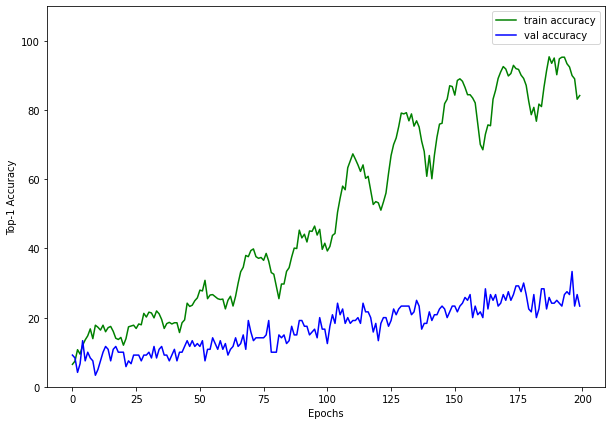

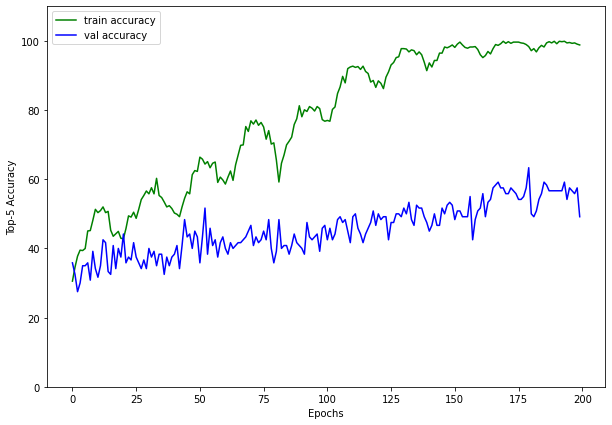

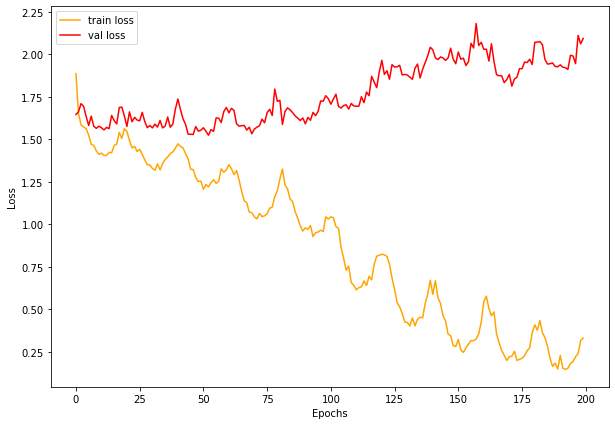

In [ ]:
# visualization
save_plots(train_acc_1, train_acc_5, val_acc_1, val_acc_5, train_loss, val_loss, "KD_simple_05_10")

## KD in generations

In [ ]:
# load teacher model
video_model, optim_video, scheduler, num_epochs = create_model(params_mobilenet_tcn, device)
teacher_model = load_model(video_model, "best_model_mobilenet_tcn_05_10.pth")
torch.manual_seed(1)
test_loss, test_acc_1, test_acc_5 = test(teacher_model, test_loader,
                                          LSR(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")

Best model was saved at 197 epochs

Test
Test loss: 3.629, test acc top-1: 36.36364, test acc top-5: 60.33058


### Generation 1

In [ ]:
params = params_mobilenet_tcn

In [ ]:
student_1, optim_video_distil_aux, scheduler_distil_aux, num_epochs_distil_aux = create_model(params_mobilenet_tcn, device)

In [ ]:
train_dataset, val_dataset, test_dataset = create_datasets(
                                                train_set_x, train_set_y,
                                                val_set_x, val_set_y,
                                                test_set_x, test_set_y)
train_loader, val_loader, test_loader = create_loaders(train_dataset, val_dataset, test_dataset, params["batch_size"], params["num_workers"])

In [ ]:
# training
train_acc_1, train_acc_5,\
val_acc_1, val_acc_5,\
train_loss, val_loss = train_model_kd(student_1, teacher_model, optim_video_distil_aux, scheduler_distil_aux,
                                      train_loader,
                                      val_loader,
                                      200, 0.5, 10, "best_model_mobilenet_tcn_gen1.pth")

[INFO]: Epoch 1 of 300
Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2887: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Test
Training loss: 2.066, training acc top-1: 6.48585, training acc top-5: 30.66038
Val loss: 1.876, val acc top-1: 10.00000, val acc top-5: 37.50000

Best val acc: 10.0

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 300
Training
Test
Training loss: 1.786, training acc top-1: 8.72642, training acc top-5: 34.19811
Val loss: 1.787, val acc top-1: 6.66667, val acc top-5: 31.66667
--------------------------------------------------
[INFO]: Epoch 3 of 300
Training
Test
Training loss: 1.768, training acc top-1: 8.96226, training acc top-5: 35.37736
Val loss: 1.849, val acc top-1: 9.16667, val acc top-5: 32.50000
--------------------------------------------------
[INFO]: Epoch 4 of 300
Training
Test
Training loss: 1.758, training acc top-1: 9.08019, training acc top-5: 37.14623
Val loss: 1.840, val acc top-1: 7.50000, val acc top-5: 27.50000
--------------------------------------------------
[INFO]: Epoch 5 of 300
Training
Test
Training 

In [ ]:
# evaluate the best model on the test set
print()
print("Evaluation on test set...")
student_model = load_model(student_1, "best_model_mobilenet_tcn_gen1.pth")
torch.manual_seed(2)
test_loss, test_acc_1, test_acc_5 = test(student_model, test_loader,
                                          LSR(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")
print()


Evaluation on test set...
Best model was saved at 276 epochs

Test
Test loss: 9.170, test acc top-1: 19.00826, test acc top-5: 44.62810



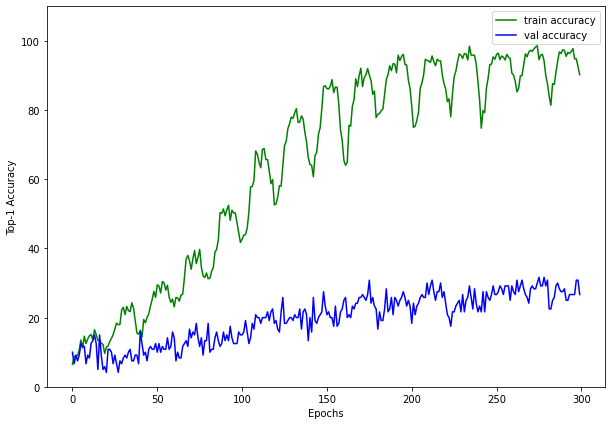

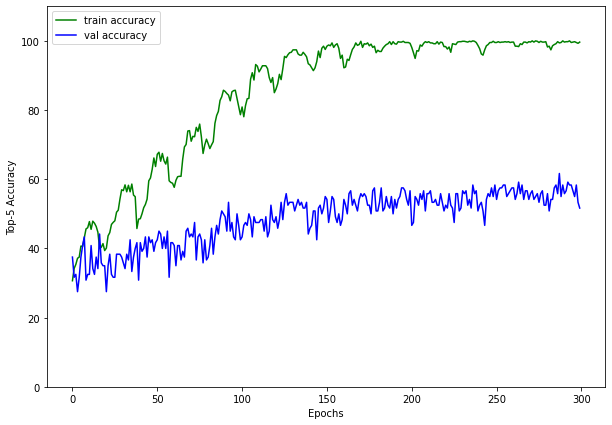

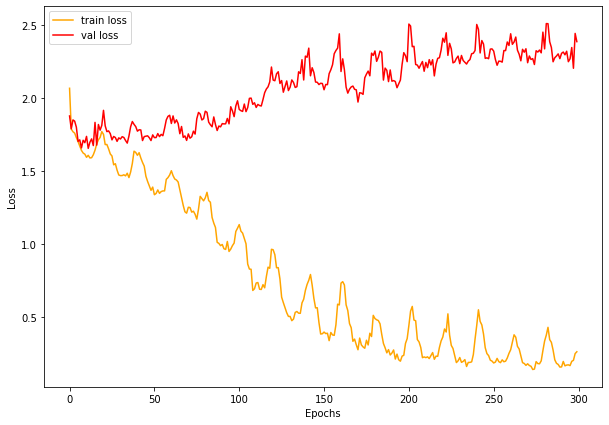

In [ ]:
# visualization
save_plots(train_acc_1, train_acc_5, val_acc_1, val_acc_5, train_loss, val_loss, "KD_gen1")

### Generation 2

In [ ]:
params = params_mobilenet_tcn
student_1, optim_video_distil_aux, scheduler_distil_aux, num_epochs_distil_aux = create_model(params_mobilenet_tcn, device)
teacher_2 = load_model(student_1, "best_model_mobilenet_tcn_gen1.pth")
torch.manual_seed(2)
test_loss, test_acc_1, test_acc_5 = test(teacher_2, test_loader,
                                          LSR(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")
print()

Best model was saved at 276 epochs

Test
Test loss: 4.101, test acc top-1: 38.01653, test acc top-5: 58.67769



In [ ]:
student_2, optim_video_distil_aux, scheduler_distil_aux, num_epochs_distil_aux = create_model(params_mobilenet_tcn, device)

In [ ]:
train_dataset, val_dataset, test_dataset = create_datasets(
                                                train_set_x, train_set_y,
                                                val_set_x, val_set_y,
                                                test_set_x, test_set_y)
train_loader, val_loader, test_loader = create_loaders(train_dataset, val_dataset, test_dataset, params["batch_size"], params["num_workers"])

In [ ]:
# training
train_acc_1, train_acc_5,\
val_acc_1, val_acc_5,\
train_loss, val_loss = train_model_kd(student_2, teacher_2, optim_video_distil_aux, scheduler_distil_aux,
                                      train_loader,
                                      val_loader,
                                      300, 0.6, 20, "best_model_mobilenet_tcn_gen2.pth")

[INFO]: Epoch 1 of 300
Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2887: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Test
Training loss: 2.198, training acc top-1: 6.72170, training acc top-5: 28.77358
Val loss: 1.967, val acc top-1: 6.66667, val acc top-5: 22.50000

Best val acc: 6.666666666666667

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 300
Training
Test
Training loss: 2.008, training acc top-1: 8.37264, training acc top-5: 31.25000
Val loss: 1.855, val acc top-1: 5.00000, val acc top-5: 28.33333
--------------------------------------------------
[INFO]: Epoch 3 of 300
Training
Test
Training loss: 1.970, training acc top-1: 9.31604, training acc top-5: 31.48585
Val loss: 1.920, val acc top-1: 7.50000, val acc top-5: 29.16667

Best val acc: 7.5

Saving best model for epoch: 3

--------------------------------------------------
[INFO]: Epoch 4 of 300
Training
Test
Training loss: 1.952, training acc top-1: 7.19340, training acc top-5: 33.60849
Val loss: 1.819, val acc top-1: 5.83333, val acc top-5: 35.00000
---------------------------------

In [ ]:
# evaluate the best model on the test set
print()
print("Evaluation on test set...")
student_model = load_model(student_2, "best_model_mobilenet_tcn_gen2.pth")
torch.manual_seed(10)
test_loss, test_acc_1, test_acc_5 = test(student_model, test_loader,
                                          LSR(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")
print()


Evaluation on test set...
Best model was saved at 300 epochs

Test
Test loss: 5.397, test acc top-1: 32.23140, test acc top-5: 55.37190



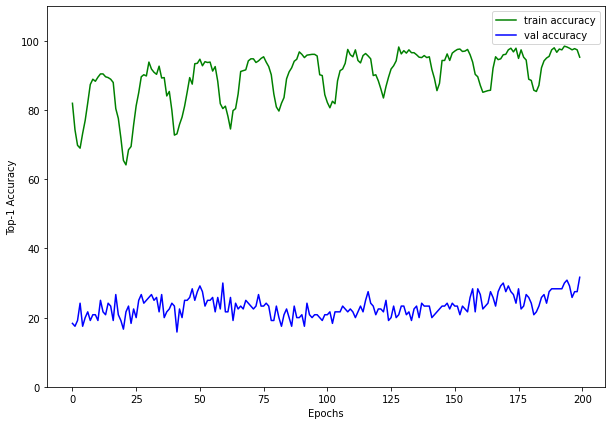

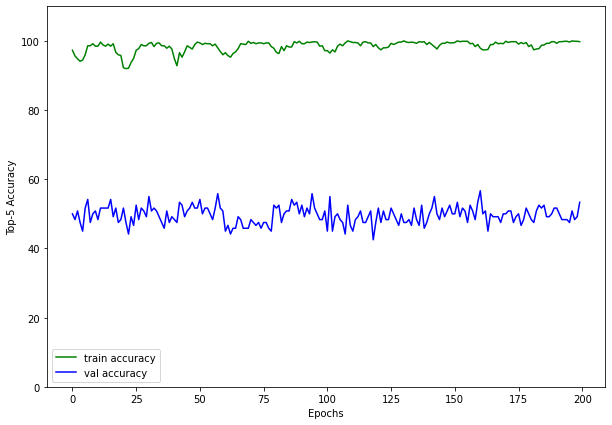

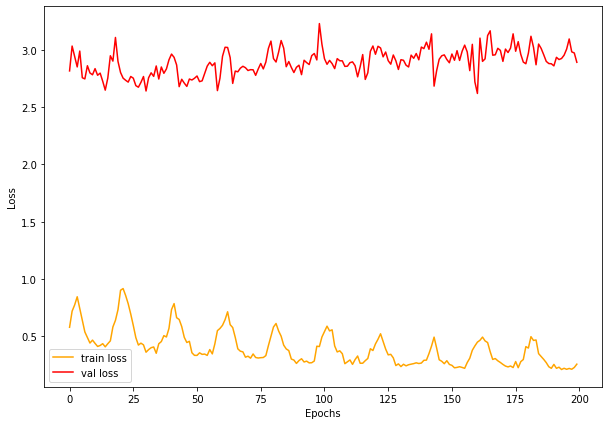

In [ ]:
# visualization
save_plots(train_acc_1, train_acc_5, val_acc_1, val_acc_5, train_loss, val_loss, "KD_gen2")

### Generation 3

# Adversarial learning with GLips and LRW

## Constants

In [ ]:
params_domain_adaptation = {
    "num_epochs": 80,
    "batch_size": 16,
    "num_workers": 2,
    "num_classes": wild_lrro_number_classes,
    "lr": 3e-4,
    "drop_prob": 0.12,
    "use_dropblock": True,
    "mixup": True,
    "se": True,
    "separable_conv": False,
    "use_tcn": True,
    "use_adam": True,
    "tcn_options": {
        "dropout": 0.1,
        "separable_conv": False,
        "kernel_size": [3, 5, 7],
        "num_layers": 4,
        "width_mult": 1
    },
    "model_filename": "best_model_domain_adaptation.pth",
    "model_graphs_folder": "DomainAdaptation"
}

params_domain_adaptation_lrw = {
    "num_epochs": 80,
    "batch_size": 16,
    "num_workers": 2,
    "num_classes": wild_lrro_number_classes,
    "lr": 3e-4,
    "drop_prob": 0.12,
    "use_dropblock": True,
    "mixup": True,
    "se": True,
    "separable_conv": False,
    "use_tcn": True,
    "use_adam": True,
    "tcn_options": {
        "dropout": 0.1,
        "separable_conv": False,
        "kernel_size": [3, 5, 7],
        "num_layers": 4,
        "width_mult": 1
    },
    "model_filename": "best_model_da_lrw.pth",
    "model_graphs_folder": "DomainAdaptation_LRW"
}

domain_tcn_options = {
    "dropout": 0.2,
    "separable_conv": True,
    "kernel_size": [5],
    "num_layers": 3,
    "width_mult": 1
}

In [ ]:
params_domain_adaptation_li = {
    "num_epochs": 80,
    "batch_size": 8,
    "num_workers": 2,
    "num_classes": wild_lrro_number_classes,
    "lr": 3e-4,
    "drop_prob": 0.12,
    "use_dropblock": True,
    "mixup": True,
    "se": True,
    "separable_conv": False,
    "use_tcn": True,
    "use_adam": True,
    "tcn_options": {
        "dropout": 0.1,
        "separable_conv": False,
        "kernel_size": [3, 5, 7],
        "num_layers": 4,
        "width_mult": 1
    },
    "model_filename": "best_model_domain_adaptation_li.pth",
    "model_graphs_folder": "DomainAdaptationLI",
    "use_li": True
}

params_domain_adaptation_gru_li = {
    "num_epochs": 80,
    "batch_size": 8,
    "num_workers": 2,
    "num_classes": wild_lrro_number_classes,
    "lr": 3e-4,
    "drop_prob": 0.12,
    "use_dropblock": True,
    "mixup": True,
    "se": True,
    "separable_conv": False,
    "use_tcn": False,
    "use_adam": True,
    "tcn_options": {
        "dropout": 0.1,
        "separable_conv": False,
        "kernel_size": [3, 5, 7],
        "num_layers": 4,
        "width_mult": 1
    },
    "model_filename": "best_model_domain_adaptation_gru_li.pth",
    "model_graphs_folder": "DomainAdaptationLI_GRU",
    "use_li": True
}

params_domain_adaptation_gru = {
    "num_epochs": 80,
    "batch_size": 8,
    "num_workers": 2,
    "num_classes": wild_lrro_number_classes,
    "lr": 3e-4,
    "drop_prob": 0.12,
    "use_dropblock": True,
    "mixup": True,
    "se": True,
    "separable_conv": False,
    "use_tcn": False,
    "use_adam": True,
    "tcn_options": {
        "dropout": 0.1,
        "separable_conv": False,
        "kernel_size": [3, 5, 7],
        "num_layers": 4,
        "width_mult": 1
    },
    "model_filename": "best_model_domain_adaptation_gru.pth",
    "model_graphs_folder": "DomainAdaptation_GRU",
    "use_li": True
}

params_multilingual_gru = {
    "num_epochs": 80,
    "batch_size": 8,
    "num_workers": 2,
    "num_classes": wild_lrro_number_classes,
    "lr": 3e-4,
    "drop_prob": 0.12,
    "use_dropblock": True,
    "mixup": True,
    "se": True,
    "separable_conv": False,
    "use_tcn": False,
    "use_adam": True,
    "tcn_options": {
        "dropout": 0.1,
        "separable_conv": False,
        "kernel_size": [3, 5, 7],
        "num_layers": 4,
        "width_mult": 1
    },
    "model_filename": "best_multilingual_gru.pth",
    "model_graphs_folder": "DomainAdaptation_GRU",
    "use_li": True,
    "num_classes_domain": 3
}

## Extracting German Dataset

In [ ]:
zipfile_path = os.path.join(mount_drive, my_drive, general_path, datasets_params_path, "GLips.zip")
with zipfile.ZipFile(zipfile_path, "r") as zip_ref:
  zip_ref.extractall(".")

In [ ]:
# datasets shapes
def print_dataset_shapes(train, val, test):
    print(train.shape)
    print(val.shape)
    print(test.shape)

In [ ]:
train_glips = np.load("train.npy")
val_glips = np.load("val.npy")
test_glips = np.load("test.npy")

# train_glips = train_glips[:2]
# test_glips = test_glips[:2]
# val_glips = val_glips[:2]
print_dataset_shapes(train_glips, val_glips, test_glips)

(848, 29, 1, 88, 88)
(121, 29, 1, 88, 88)
(120, 29, 1, 88, 88)


## Extracting English Dataset

In [ ]:
zipfile_path = os.path.join(mount_drive, my_drive, general_path, datasets_params_path, "LRW.zip")
with zipfile.ZipFile(zipfile_path, "r") as zip_ref:
  zip_ref.extractall(".")

In [ ]:
train_lrw = np.load("train_lrw.npy")
val_lrw = np.load("val_lrw.npy")
test_lrw = np.load("test_lrw.npy")

print_dataset_shapes(train_lrw, val_lrw, test_lrw)

(848, 29, 1, 88, 88)
(121, 29, 1, 88, 88)
(120, 29, 1, 88, 88)


## Create Source and Target Domains Dataloaders

### Simple Domain Adaptation

#### Helpers

In [ ]:
class TargetDomainDataset(Dataset):
  def __init__(self, video_list):
    self.video_list = video_list

  def __len__(self):
    return len(self.video_list)

  def __getitem__(self, i):
    video = self.video_list[i]
    video = np.asarray(video).reshape(NUMBER_FRAMES, 1, IMAGE_WIDTH, IMAGE_HEIGHT)
    video = torch.tensor(video, dtype=torch.float)
    return video

In [ ]:
def create_da_datasets(train_set_x, val_set_x, test_set_x):
  # create the training set dataloader
  train_dataset = TargetDomainDataset(train_set_x)

  # create the validation set dataloader
  val_dataset = TargetDomainDataset(val_set_x)

  # create the test set dataloader
  test_dataset = TargetDomainDataset(test_set_x)

  return train_dataset, val_dataset, test_dataset

In [ ]:
def create_da_loaders(train_dataset, val_dataset, test_dataset, batch_size, num_workers):
  train_loader = DataLoader(train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=True,
            drop_last=False,
            pin_memory=True)

  val_loader = DataLoader(val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=False,
            drop_last=False,
            pin_memory=True)

  test_loader = DataLoader(test_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=False,
            drop_last=False,
            pin_memory=True)

  return train_loader, val_loader, test_loader

#### Creating

In [ ]:
params = params_domain_adaptation_li

In [ ]:
# Romanian Dataloader
train_dataset, val_dataset, test_dataset = create_datasets(train_set_x, train_set_y,
                                                           val_set_x, val_set_y,
                                                           test_set_x, test_set_y)
train_loader_ro, val_loader_ro, test_loader_ro = create_loaders(train_dataset, val_dataset, test_dataset, params["batch_size"], params["num_workers"])

In [ ]:
# German Dataloader
train_dataset, val_dataset, test_dataset = create_da_datasets(train_glips, val_glips, test_glips)
train_loader_de, val_loader_de, test_loader_de = create_da_loaders(train_dataset, val_dataset, test_dataset, params["batch_size"], params["num_workers"])

In [ ]:
# English Dataloader
#train_dataset, val_dataset, test_dataset = create_da_datasets(train_lrw, val_lrw, test_lrw)
#train_loader_en, val_loader_en, test_loader_en = create_da_loaders(train_dataset, val_dataset, test_dataset, params["batch_size"], params["num_workers"])

### Multilingual Domain Adaptation

In [ ]:
class TargetDomainDatasetML(Dataset):
  def __init__(self, video_list, label=1):
    self.video_list = video_list
    self.label = label

  def __len__(self):
    return len(self.video_list)

  def __getitem__(self, i):
    video = self.video_list[i]
    video = np.asarray(video).reshape(NUMBER_FRAMES, 1, IMAGE_WIDTH, IMAGE_HEIGHT)
    video = torch.tensor(video, dtype=torch.float)
    return video, self.label

In [ ]:
def create_da_datasets_ml(train_set_x, val_set_x, test_set_x, label=1):
  # create the training set dataloader
  train_dataset = TargetDomainDatasetML(train_set_x, label=label)

  # create the validation set dataloader
  val_dataset = TargetDomainDatasetML(val_set_x, label=label)

  # create the test set dataloader
  test_dataset = TargetDomainDatasetML(test_set_x, label=label)

  return train_dataset, val_dataset, test_dataset

In [ ]:
def create_da_loaders_ml(train_dataset, val_dataset, test_dataset, batch_size, num_workers):
  train_loader = DataLoader(train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=True,
            drop_last=False,
            pin_memory=True)

  val_loader = DataLoader(val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=False,
            drop_last=False,
            pin_memory=True)

  test_loader = DataLoader(test_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=False,
            drop_last=False,
            pin_memory=True)

  return train_loader, val_loader, test_loader

In [ ]:
params = params_multilingual_gru

In [ ]:
# Romanian Dataloader
train_dataset, val_dataset, test_dataset = create_datasets(train_set_x, train_set_y,
                                                           val_set_x, val_set_y,
                                                           test_set_x, test_set_y)
train_loader_ro, val_loader_ro, test_loader_ro = create_loaders(train_dataset, val_dataset, test_dataset, params["batch_size"], params["num_workers"])

In [ ]:
# German Dataset
train_dataset_de, val_dataset_de, test_dataset_de = create_da_datasets_ml(train_glips, val_glips, test_glips, label=1)

In [ ]:
# English Dataset
train_dataset_en, val_dataset_en, test_dataset_en = create_da_datasets_ml(train_lrw, val_lrw, test_lrw, label=2)

In [ ]:
# Combined dataset
train_dataset = torch.utils.data.ConcatDataset([train_dataset_de, train_dataset_en])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_de, val_dataset_en])
val_dataset = torch.utils.data.ConcatDataset([test_dataset_de, test_dataset_en])
train_loader_ml, val_loader_ml, test_loader_ml = create_da_loaders_ml(train_dataset, val_dataset, test_dataset, params["batch_size"], params["num_workers"])

In [ ]:
print(len(train_loader_ro.dataset))
print(len(train_loader_ml.dataset))

848
1696


## Domain Adaptation Model

In [ ]:
from torch.autograd import Function

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

In [ ]:
# backend model
class VideoModelDomainAdaptation(nn.Module):
    def __init__(self, number_classes, dropout=0.6, drop_prob=0, se=False,
                 use_dropblock=False, separable_conv=False, use_tcn=False, tcn_options={}, domain_tcn_options={}, use_li=False,
                 num_classes_domain=2):
        super(VideoModelDomainAdaptation, self).__init__()

        self.frontend_out = 64
        self.backend_out = 512
        self.trunk = ResNet(BasicBlock, [2, 2, 2, 2], drop_prob, se=se,
                              use_dropblock=use_dropblock,
                              separable_conv=separable_conv)

        # frontend3D
        self.frontend3D = nn.Sequential(
                nn.Conv3d(1, self.frontend_out, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False),
                nn.BatchNorm3d(self.frontend_out),
                nn.ReLU(True),
                nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
                )

        # word classifier
        self.number_classes = number_classes
        self.use_tcn = use_tcn
        self.use_li = use_li

        self.dropout = nn.Dropout(p=dropout)
        hidden_dim = 1024
        if use_tcn:
          tcn_class = TCN if len(tcn_options['kernel_size']) == 1 else MultiscaleMultibranchTCN
          self.tcn = tcn_class(input_size=self.backend_out,
                              num_channels=[hidden_dim * len(tcn_options['kernel_size']) * tcn_options['width_mult']] * tcn_options['num_layers'],
                              num_classes=number_classes,
                              tcn_options=tcn_options,
                              dropout=tcn_options['dropout'],
                              separable_conv=tcn_options['separable_conv'],
                              use_li=use_li)
        else:
          self.gru = nn.GRU(self.backend_out, hidden_dim, 3, batch_first=True, bidirectional=True, dropout=0.25)
          self.v_cls = nn.Linear(1024 * 2, self.number_classes)
          self.li = LateralInhibition(1024 * 2, 10)

        # domain classifier
        self.domain_classifier = TCN(input_size=self.backend_out,
                                    num_channels=[hidden_dim * domain_tcn_options['width_mult']] * domain_tcn_options['num_layers'],
                                    num_classes=num_classes_domain,
                                    tcn_options=domain_tcn_options,
                                    dropout=domain_tcn_options['dropout'],
                                    separable_conv=domain_tcn_options["separable_conv"])
        self.softmax = nn.Softmax(dim=1)
        self._initialize_weights()

    def video_cnn(self, x):
      b, t = x.size()[:2]
      x = x.transpose(1, 2)
      x = self.frontend3D(x)
      x = x.transpose(1, 2)
      x = x.contiguous()
      x = x.view(-1, self.frontend_out, x.size(3), x.size(4))
      x = self.trunk(x)
      x = x.view(b, -1, self.backend_out)
      return x

    def forward(self, v, grl_lambda=1.0):
        if not self.use_tcn:
          self.gru.flatten_parameters()

        # lip reading classification
        if(self.training):
            f_v = self.video_cnn(v)
            f_v = self.dropout(f_v)
            f_v = f_v.float()
        else:
            f_v = self.video_cnn(v)
            f_v = self.dropout(f_v)

        if self.use_tcn:
          y_v = self.tcn(f_v)
        else:
          h, _ = self.gru(f_v)
          h = self.dropout(h)
          if self.use_li:
            h = self.li(h)
          y_v = self.v_cls(h).mean(1)

        # domain classification
        reversed_f_v = GradientReversalFn.apply(f_v, grl_lambda)
        domain_pred = self.domain_classifier(reversed_f_v)
        domain_pred = self.softmax(domain_pred)

        return y_v, domain_pred

    # initialize layers
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()

            elif isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()

            elif isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()

            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [ ]:
def create_model_domain(params, domain_options, device):
  video_model = VideoModelDomainAdaptation(params["num_classes"],
                           drop_prob=params["drop_prob"],
                           se=params["se"],
                           use_dropblock=params["use_dropblock"],
                           separable_conv=params["separable_conv"],
                           use_tcn=params["use_tcn"],
                           tcn_options=params["tcn_options"],
                           domain_tcn_options=domain_options)

  optim_video, scheduler = create_optim_scheduler(video_model, params["lr"], params["num_epochs"], params["use_adam"])

  if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    video_model = nn.DataParallel(video_model)

  video_model = video_model.to(device)
  return video_model, optim_video, scheduler, params["num_epochs"]

def create_model_domain_li(params, domain_options, device):
  video_model = VideoModelDomainAdaptation(params["num_classes"],
                           drop_prob=params["drop_prob"],
                           se=params["se"],
                           use_dropblock=params["use_dropblock"],
                           separable_conv=params["separable_conv"],
                           use_tcn=params["use_tcn"],
                           tcn_options=params["tcn_options"],
                           domain_tcn_options=domain_options,
                           use_li=params["use_li"])

  optim_video, scheduler = create_optim_scheduler(video_model, params["lr"], params["num_epochs"], params["use_adam"])

  if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    video_model = nn.DataParallel(video_model)

  video_model = video_model.to(device)
  return video_model, optim_video, scheduler, params["num_epochs"]

def create_model_domain_multilingual(params, domain_options, device):
  video_model = VideoModelDomainAdaptation(params["num_classes"],
                           drop_prob=params["drop_prob"],
                           se=params["se"],
                           use_dropblock=params["use_dropblock"],
                           separable_conv=params["separable_conv"],
                           use_tcn=params["use_tcn"],
                           tcn_options=params["tcn_options"],
                           domain_tcn_options=domain_options,
                           use_li=params["use_li"],
                           num_classes_domain=params["num_classes_domain"])

  optim_video, scheduler = create_optim_scheduler(video_model, params["lr"], params["num_epochs"], params["use_adam"])

  if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    video_model = nn.DataParallel(video_model)

  video_model = video_model.to(device)
  return video_model, optim_video, scheduler, params["num_epochs"]

In [ ]:
adversarial_model, optim_video, scheduler, num_epochs = create_model_domain(params, domain_tcn_options, device)

In [ ]:
# model summary
#summary(adversarial_model, input_size=(29, 1, 88, 88))

## Training and Evaluation functions

In [ ]:
def train_domain_adaptation(model, epoch, n_epochs, trainloader_source, trainloader_target, optimizer, scheduler, criterion, domain_criterion, device, mixup):
    train_running_loss = 0.0
    train_running_correct_1, train_running_correct_5 = 0, 0
    counter = 0

    len_dataloader = min(len(trainloader_source), len(trainloader_target))
    data_source_iter = iter(trainloader_source)
    data_target_iter = iter(trainloader_target)

    print("Training")
    model.train()

    i = 0
    while i < len_dataloader:
      counter += 1
      p = float(i + epoch * len_dataloader) / n_epochs / len_dataloader
      grl_lambda = 2. / (1. + np.exp(-10 * p)) - 1
      grl_lambda = torch.tensor(grl_lambda)

      # Source Dataset
      data_source = data_source_iter.next()
      video_source, label_source = data_source
      video_source = video_source.to(device)
      label_source = label_source.to(device)
      domain_label = torch.zeros(video_source.shape[0], dtype=torch.long).to(device)

      optimizer.zero_grad(set_to_none = True)

      # mixing videos in batch for data augmentation + forward pass
      if mixup:
          lambda_ = np.random.beta(alpha, alpha)
          index = torch.randperm(video_source.size(0))

          mix_video = lambda_ * video_source + (1 - lambda_) * video_source[index, :]
          label_a, label_b = label_source, label_source[index]
          label_domain_a, label_domain_b = domain_label, domain_label[index]

          y_v, domain_pred = model(mix_video, grl_lambda)
          del mix_video

          # also mix losses
          loss_source_word = lambda_ * criterion(y_v, label_a) + (1 - lambda_) * criterion(y_v, label_b)
          loss_source_domain = lambda_ * domain_criterion(domain_pred, label_domain_a) + (1 - lambda_) * domain_criterion(domain_pred, label_domain_b)
      else:
          # simple forward pass
          y_v, domain_pred = model(video_source, grl_lambda)
          loss_source_word = criterion(y_v, label_source)
          loss_source_domain = domain_criterion(domain_pred, domain_label)

      del data_source, video_source, domain_label, domain_pred

      # Target Dataset
      data_target = data_target_iter.next()
      video_target = data_target
      video_target = video_target.to(device)

      domain_label_target = torch.ones(video_target.shape[0], dtype=torch.long).to(device)
      _, domain_pred_target = model(video_target, grl_lambda)
      loss_target_domain = domain_criterion(domain_pred_target, domain_label_target)

      loss = loss_source_word + loss_source_domain + loss_target_domain

      # compute loss
      train_running_loss += loss.detach().item()

      # compute top-1 and top-5 correct predictions from the softmax scores
      correct1, correct5 = correct_predictions_topk(y_v, label_source, topk=(1, 5))
      train_running_correct_1 += correct1.item()
      train_running_correct_5 += correct5.item()

      del data_target, video_target, correct1, correct5, domain_pred_target, domain_label_target, y_v
      del label_source

      # backpropagation
      loss.backward()
      del loss

      # update the optimizer parameters
      optimizer.step()
      i += 1

    # update learning rate with scheduler (cosine scheduling)
    scheduler.step()

    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc_1 = 100. * (train_running_correct_1 / len(trainloader_source.dataset))
    epoch_acc_5 = 100. * (train_running_correct_5 / len(trainloader_source.dataset))
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def train_model_domain(model, optim_video, scheduler,
                       train_loader_source, val_loader_source,
                       train_loader_target, val_loader_target,
                       num_epochs, mixup, model_filename):
  train_loss, val_loss = [], []
  train_acc_1, train_acc_5, val_acc_1, val_acc_5 = [], [], [], []

  criterion = LSR()
  domain_criterion = nn.CrossEntropyLoss()
  save_best_model = SaveBestModelAcc(model_filename)
  with torch.no_grad():
      torch.cuda.empty_cache()

  for epoch in range(num_epochs):
    print(f"[INFO]: Epoch {epoch + 1} of {num_epochs}")
    train_epoch_loss, train_epoch_acc_1, train_epoch_acc_5 = train_domain_adaptation(model, epoch, num_epochs,
                                              train_loader_source, train_loader_target,
                                              optim_video, scheduler,
                                              criterion, domain_criterion,
                                              device, mixup)

    val_epoch_loss, val_epoch_acc_1, val_epoch_acc_5 = test_domain(model, val_loader_source, val_loader_target,
                                                  criterion, domain_criterion, device)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

    train_acc_1.append(train_epoch_acc_1)
    train_acc_5.append(train_epoch_acc_5)

    val_acc_1.append(val_epoch_acc_1)
    val_acc_5.append(val_epoch_acc_5)

    print(f"Training loss: {train_epoch_loss:.3f}, training acc top-1: {train_epoch_acc_1:.5f}, training acc top-5: {train_epoch_acc_5:.5f}")
    print(f"Val loss: {val_epoch_loss:.3f}, val acc top-1: {val_epoch_acc_1:.5f}, val acc top-5: {val_epoch_acc_5:.5f}")

    # save the best model till now if we have the least loss in the current epoch
    save_best_model(val_epoch_acc_1, epoch, model, optim_video)
    print('-'*50)
    torch.cuda.empty_cache()

  print("TRAINING COMPLETE")

  return train_acc_1, train_acc_5, val_acc_1, val_acc_5, train_loss, val_loss

In [ ]:
def test_domain(model, testloader_source, testloader_target, criterion, domain_criterion, device):
    test_running_loss = 0.0
    test_running_correct_1 = 0
    test_running_correct_5 = 0
    counter = 0

    len_dataloader = min(len(testloader_source), len(testloader_target))
    data_source_iter = iter(testloader_source)
    data_target_iter = iter(testloader_target)

    print("Test")
    model.eval()
    with torch.no_grad():
      i = 0
      while i < len_dataloader:
        counter += 1

        # source dataset
        data_source = data_source_iter.next()
        video_source, label_source = data_source
        video_source = video_source.to(device)
        label_source = label_source.to(device)
        domain_label = torch.zeros(video_source.shape[0], dtype=torch.long).to(device)

        y_v, domain_pred = model(video_source, 0)
        loss_source = criterion(y_v, label_source)
        loss_source_domain = domain_criterion(domain_pred, domain_label)

        # target dataset
        data_target = data_target_iter.next()
        video_target = data_target
        video_target = video_target.to(device)
        domain_label_target = torch.ones(video_target.shape[0], dtype=torch.long).to(device)

        _, domain_pred_target = model(video_target, 0)
        loss_target_domain = domain_criterion(domain_pred_target, domain_label_target)

        loss = loss_source + loss_source_domain + loss_target_domain

        # compute loss
        test_running_loss += loss.detach().item()

        # compute top-1 and top-5 correct predictions from the softmax scores
        correct1, correct5 = correct_predictions_topk(y_v, label_source, topk=(1, 5))
        test_running_correct_1 += correct1.item()
        test_running_correct_5 += correct5.item()

        del data_source, data_target, video_source, video_target, y_v, loss, correct1, correct5
        i += 1

    # loss and accuracy for the complete epoch
    epoch_loss = test_running_loss / counter
    epoch_acc_1 = 100. * (test_running_correct_1 / len(testloader_source.dataset))
    epoch_acc_5 = 100. * (test_running_correct_5 / len(testloader_source.dataset))
    return epoch_loss, epoch_acc_1, epoch_acc_5

## Training and Visualisation for GLips


In [ ]:
params = params_domain_adaptation

In [ ]:
adversarial_model = load_model(adversarial_model, params["model_filename"])

In [ ]:
adversarial_model, optim_video, scheduler, num_epochs = create_model_domain(params, domain_tcn_options, device)

[3072, 3072, 3072, 3072]


In [ ]:
train_acc_1, train_acc_5,\
val_acc_1, val_acc_5,\
train_loss, val_loss = train_model_domain(adversarial_model, optim_video, scheduler,
                                          train_loader_ro, val_loader_ro,
                                          train_loader_de, val_loader_de,
                                          params["num_epochs"], params["mixup"], params["model_filename"])

In [ ]:
# evaluate the best model on the test set
print()
print("Evaluation on test set...")
model = load_model(adversarial_model, params["model_filename"])
torch.manual_seed(1)
test_loss, test_acc_1, test_acc_5 = test_domain(model, test_loader_ro, test_loader_de,
                                          LSR(), nn.CrossEntropyLoss(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")
print()

In [ ]:
print(params["model_filename"])

best_model_domain_adaptation.pth


In [ ]:
save_plots(train_acc_1, train_acc_5, val_acc_1, val_acc_5, train_loss, val_loss, params["model_graphs_folder"])

## Training and Visualisation for LRW

In [ ]:
params = params_domain_adaptation_lrw

In [ ]:
adversarial_model, optim_video, scheduler, num_epochs = create_model_domain(params, domain_tcn_options, device)

[3072, 3072, 3072, 3072]


In [ ]:
# adversarial_model = load_model(adversarial_model, params["model_filename"])

In [ ]:
train_acc_1, train_acc_5,\
val_acc_1, val_acc_5,\
train_loss, val_loss = train_model_domain(adversarial_model, optim_video, scheduler,
                                          train_loader_ro, val_loader_ro,
                                          train_loader_en, val_loader_en,
                                          params["num_epochs"], params["mixup"], params["model_filename"])

[INFO]: Epoch 1 of 100
Training
Test
Training loss: 7.241, training acc top-1: 6.72170, training acc top-5: 30.42453
Val loss: 4.477, val acc top-1: 10.00000, val acc top-5: 35.00000

Best val acc: 10.0

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 100
Training
Test
Training loss: 4.421, training acc top-1: 7.90094, training acc top-5: 35.73113
Val loss: 4.367, val acc top-1: 10.00000, val acc top-5: 40.83333
--------------------------------------------------
[INFO]: Epoch 3 of 100
Training
Test
Training loss: 4.392, training acc top-1: 8.96226, training acc top-5: 35.49528
Val loss: 4.421, val acc top-1: 10.00000, val acc top-5: 40.00000
--------------------------------------------------
[INFO]: Epoch 4 of 100
Training
Test
Training loss: 4.361, training acc top-1: 8.13679, training acc top-5: 36.08491
Val loss: 4.566, val acc top-1: 10.83333, val acc top-5: 38.33333

Best val acc: 10.833333333333334

Saving best model for epoch

In [ ]:
# evaluate the best model on the test set
print()
print("Evaluation on test set...")
model = load_model(adversarial_model, params["model_filename"])
torch.manual_seed(3)
test_loss, test_acc_1, test_acc_5 = test_domain(model, test_loader_ro, test_loader_en,
                                          LSR(), nn.CrossEntropyLoss(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")
print()


Evaluation on test set...
Best model was saved at 96 epochs

Test
Test loss: 3.679, test acc top-1: 47.93388, test acc top-5: 73.55372



In [ ]:
print(params["model_filename"])

best_model_da_lrw.pth


In [ ]:
save_plots(train_acc_1, train_acc_5, val_acc_1, val_acc_5, train_loss, val_loss, params["model_graphs_folder"])

# Testing without dropblock

## MSTCN

In [ ]:
params = params_resnet_mstcn
video_model, optim_video, scheduler, num_epochs = create_model(params, device)

[3072, 3072, 3072, 3072]


In [ ]:
# model summary
summary(video_model, input_size=(29, 1, 88, 88))
# macs, params = get_model_complexity_info(video_model, (29, 1, 88, 88), as_strings=True, print_per_layer_stat=True, verbose=True)
# print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
# print('{:<30}  {:<8}'.format('Number of parameters: ', params))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 29, 44, 44]          15,680
       BatchNorm3d-2       [-1, 64, 29, 44, 44]             128
              ReLU-3       [-1, 64, 29, 44, 44]               0
         MaxPool3d-4       [-1, 64, 29, 22, 22]               0
            Conv2d-5           [-1, 64, 22, 22]          36,864
       BatchNorm2d-6           [-1, 64, 22, 22]             128
         DropBlock-7           [-1, 64, 22, 22]               0
   LinearScheduler-8           [-1, 64, 22, 22]               0
              ReLU-9           [-1, 64, 22, 22]               0
           Conv2d-10           [-1, 64, 22, 22]          36,864
      BatchNorm2d-11           [-1, 64, 22, 22]             128
        DropBlock-12           [-1, 64, 22, 22]               0
  LinearScheduler-13           [-1, 64, 22, 22]               0
AdaptiveAvgPool2d-14             [-1, 6

In [ ]:
train_dataset, val_dataset, test_dataset = create_datasets(
                                                train_set_x, train_set_y,
                                                val_set_x, val_set_y,
                                                test_set_x, test_set_y)
train_loader, val_loader, test_loader = create_loaders(train_dataset, val_dataset, test_dataset, params["batch_size"], params["num_workers"])

In [ ]:
train_acc_1, train_acc_5,\
val_acc_1, val_acc_5,\
train_loss, val_loss = train_model(video_model, optim_video, scheduler,
                                              train_loader,
                                              val_loader,
                                              num_epochs, params["mixup"], params["model_filename"])

In [ ]:
# evaluate the best model on the test set
print()
print("Evaluation on test set...")
model = load_model(video_model, params["model_filename"])
torch.manual_seed(4)
test_loss, test_acc_1, test_acc_5 = test(model, test_loader,
                                          LSR(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")
print()


Evaluation on test set...
Best model was saved at 55 epochs

Test
Test loss: 2.725, test acc top-1: 36.36364, test acc top-5: 64.46281



In [ ]:
params["model_graphs_folder"]

'ResnetMSTCN_nodrop'

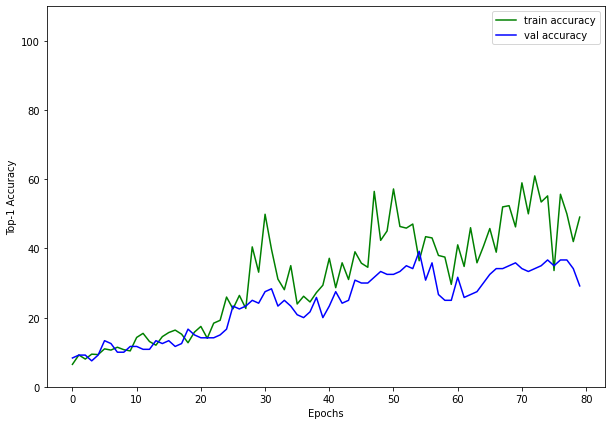

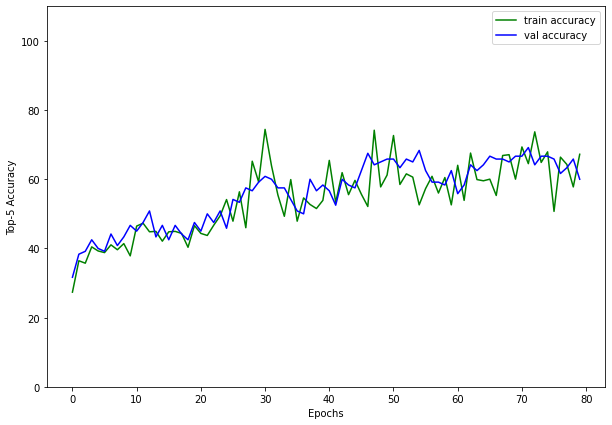

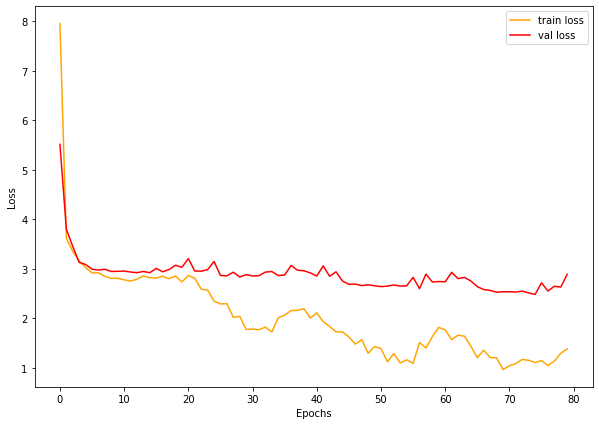

In [ ]:
save_plots(train_acc_1, train_acc_5, val_acc_1, val_acc_5, train_loss, val_loss, params["model_graphs_folder"])

## GRU

In [ ]:
params = params_resnet_gru
video_model, optim_video, scheduler, num_epochs = create_model(params, device)

In [ ]:
# model summary
summary(video_model, input_size=(29, 1, 88, 88))
# macs, params = get_model_complexity_info(video_model, (29, 1, 88, 88), as_strings=True, print_per_layer_stat=True, verbose=True)
# print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
# print('{:<30}  {:<8}'.format('Number of parameters: ', params))

In [ ]:
train_dataset, val_dataset, test_dataset = create_datasets(
                                                train_set_x, train_set_y,
                                                val_set_x, val_set_y,
                                                test_set_x, test_set_y)
train_loader, val_loader, test_loader = create_loaders(train_dataset, val_dataset, test_dataset, params["batch_size"], params["num_workers"])

In [ ]:
train_acc_1, train_acc_5,\
val_acc_1, val_acc_5,\
train_loss, val_loss = train_model(video_model, optim_video, scheduler,
                                              train_loader,
                                              val_loader,
                                              num_epochs, params["mixup"], params["model_filename"])

In [ ]:
print(params["model_filename"])

best_model_resnet18_gru_nodrop.pth


In [ ]:
# evaluate the best model on the test set
print()
print("Evaluation on test set...")
model = load_model(video_model, params["model_filename"])
torch.manual_seed(3)
test_loss, test_acc_1, test_acc_5 = test(model, test_loader,
                                          LSR(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")
print()


Evaluation on test set...
Best model was saved at 48 epochs

Test
Test loss: 2.628, test acc top-1: 36.36364, test acc top-5: 62.80992



In [ ]:
params["model_graphs_folder"]

'ResnetGRU_nodrop'

In [ ]:
save_plots(train_acc_1, train_acc_5, val_acc_1, val_acc_5, train_loss, val_loss, params["model_graphs_folder"])

# Metrics

## Functions

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
def test_metrics(model, testloader, criterion, device, model_name):
    test_running_loss = 0.0
    test_running_correct_1 = 0
    test_running_correct_5 = 0
    counter = 0

    print("Test")
    outputs = []
    labels = []
    with torch.no_grad():
      for i, data in enumerate(testloader):
        counter += 1
        video, label = data
        video = video.to(device)
        label = label.to(device)
        labels.extend(label.cpu())

        # forward pass
        y_v = model(video)
        loss = criterion(y_v, label)

        # compute loss
        test_running_loss += loss.detach().item()

        # compute top-1 and top-5 correct predictions from the softmax scores
        correct1, correct5 = correct_predictions_topk(y_v, label, topk=(1, 5))
        test_running_correct_1 += correct1.item()
        test_running_correct_5 += correct5.item()

        probs = F.softmax(y_v, dim = 1).cpu()
        out = np.argmax(probs, axis=-1)
        outputs.extend(out)
        del data, video, label, y_v, loss, correct1, correct5


    # loss and accuracy for the complete epoch
    epoch_loss = test_running_loss / counter
    epoch_acc_1 = 100. * (test_running_correct_1 / len(testloader.dataset))
    epoch_acc_5 = 100. * (test_running_correct_5 / len(testloader.dataset))

    # precision = precision_score(outputs, labels)
    # recall = recall_score(outputs, labels)
    # f1 = f1_score(outputs, labels)

    print(classification_report(labels, outputs, digits=5))
    cf_matrix = confusion_matrix(labels, outputs)

    df_cm = pd.DataFrame(cf_matrix, index=label_dict_wild.keys(), columns=label_dict_wild.keys())
    plt.figure(figsize = (10,7))
    ax = sns.heatmap(df_cm, annot=True)
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    graph_folder = os.path.join(mount_drive, my_drive, general_path, graphs_params_path, model_name)
    plt.savefig(os.path.join(graph_folder, "confusion_matrix"))

    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def test_domain(model, testloader_source, testloader_target, criterion, domain_criterion, device):
    test_running_loss = 0.0
    test_running_correct_1 = 0
    test_running_correct_5 = 0
    counter = 0

    len_dataloader = min(len(testloader_source), len(testloader_target))
    data_source_iter = iter(testloader_source)
    data_target_iter = iter(testloader_target)

    print("Test")
    model.eval()
    with torch.no_grad():
      i = 0
      while i < len_dataloader:
        counter += 1

        # source dataset
        data_source = data_source_iter.next()
        video_source, label_source = data_source
        video_source = video_source.to(device)
        label_source = label_source.to(device)
        domain_label = torch.zeros(video_source.shape[0], dtype=torch.long).to(device)

        y_v, domain_pred = model(video_source, 0)
        loss_source = criterion(y_v, label_source)
        loss_source_domain = domain_criterion(domain_pred, domain_label)

        # target dataset
        data_target = data_target_iter.next()
        video_target = data_target
        video_target = video_target.to(device)
        domain_label_target = torch.ones(video_target.shape[0], dtype=torch.long).to(device)

        _, domain_pred_target = model(video_target, 0)
        loss_target_domain = domain_criterion(domain_pred_target, domain_label_target)

        loss = loss_source + loss_source_domain + loss_target_domain

        # compute loss
        test_running_loss += loss.detach().item()

        # compute top-1 and top-5 correct predictions from the softmax scores
        correct1, correct5 = correct_predictions_topk(y_v, label_source, topk=(1, 5))
        test_running_correct_1 += correct1.item()
        test_running_correct_5 += correct5.item()

        del data_source, data_target, video_source, video_target, y_v, loss, correct1, correct5
        i += 1

    # loss and accuracy for the complete epoch
    epoch_loss = test_running_loss / counter
    epoch_acc_1 = 100. * (test_running_correct_1 / len(testloader_source.dataset))
    epoch_acc_5 = 100. * (test_running_correct_5 / len(testloader_source.dataset))
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def test_metrics_domain(model, testloader_source, testloader_target, criterion, domain_criterion, device, model_name):
    test_running_loss = 0.0
    test_running_correct_1 = 0
    test_running_correct_5 = 0
    counter = 0

    print("Test")
    outputs = []
    labels = []

    len_dataloader = min(len(testloader_source), len(testloader_target))
    data_source_iter = iter(testloader_source)
    data_target_iter = iter(testloader_target)

    print("Test")
    model.eval()
    with torch.no_grad():
      i = 0
      while i < len_dataloader:
        counter += 1

        # source dataset
        data_source = data_source_iter.next()
        video_source, label_source = data_source
        video_source = video_source.to(device)
        label_source = label_source.to(device)
        labels.extend(label_source.cpu())
        domain_label = torch.zeros(video_source.shape[0], dtype=torch.long).to(device)

        y_v, domain_pred = model(video_source, 0)
        loss_source = criterion(y_v, label_source)
        loss_source_domain = domain_criterion(domain_pred, domain_label)

        # target dataset
        data_target = data_target_iter.next()
        video_target = data_target
        video_target = video_target.to(device)
        domain_label_target = torch.ones(video_target.shape[0], dtype=torch.long).to(device)

        _, domain_pred_target = model(video_target, 0)
        loss_target_domain = domain_criterion(domain_pred_target, domain_label_target)

        loss = loss_source + loss_source_domain + loss_target_domain

        # compute loss
        test_running_loss += loss.detach().item()

        # compute top-1 and top-5 correct predictions from the softmax scores
        correct1, correct5 = correct_predictions_topk(y_v, label_source, topk=(1, 5))
        test_running_correct_1 += correct1.item()
        test_running_correct_5 += correct5.item()

        probs = F.softmax(y_v, dim = 1).cpu()
        out = np.argmax(probs, axis=-1)
        outputs.extend(out)

        del data_source, data_target, video_source, video_target, y_v, loss, correct1, correct5
        i += 1

    # loss and accuracy for the complete epoch
    epoch_loss = test_running_loss / counter
    epoch_acc_1 = 100. * (test_running_correct_1 / len(testloader_source.dataset))
    epoch_acc_5 = 100. * (test_running_correct_5 / len(testloader_source.dataset))

    print(classification_report(labels, outputs, digits=5))
    cf_matrix = confusion_matrix(labels, outputs)

    df_cm = pd.DataFrame(cf_matrix, index=label_dict_wild.keys(), columns=label_dict_wild.keys())
    plt.figure(figsize = (10,7))
    ax = sns.heatmap(df_cm, annot=True)
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    graph_folder = os.path.join(mount_drive, my_drive, general_path, graphs_params_path, model_name)
    plt.savefig(os.path.join(graph_folder, "confusion_matrix"))

    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def get_metrics(params, seed_value, model_name, model_filename=None):
  if model_filename == None:
    filename = params["model_filename"]
  else:
    filename = model_filename
  video_model, optim_video, scheduler, num_epochs = create_model(params, device)
  model = load_model(video_model, filename)
  torch.manual_seed(seed_value)
  train_dataset, val_dataset, test_dataset = create_datasets(
                                                  train_set_x, train_set_y,
                                                  val_set_x, val_set_y,
                                                  test_set_x, test_set_y)
  train_loader, val_loader, test_loader = create_loaders(train_dataset, val_dataset, test_dataset, params["batch_size"], params["num_workers"])
  test_loss, test_acc_1, test_acc_5 = test_metrics(model, test_loader,
                                          LSR(), device, model_name)
  print(test_acc_1, test_acc_5)
  return test_acc_1, test_acc_5

In [ ]:
def get_metrics_domain(params, seed_value, model_name, model_filename=None):
  if model_filename == None:
    filename = params["model_filename"]
  else:
    filename = model_filename
  video_model, optim_video, scheduler, num_epochs = create_model_domain(params, domain_tcn_options, device)
  model = load_model(video_model, filename)
  torch.manual_seed(seed_value)

  # Romanian Dataloader
  train_dataset, val_dataset, test_dataset = create_datasets(train_set_x, train_set_y,
                                                           val_set_x, val_set_y,
                                                           test_set_x, test_set_y)
  train_loader_ro, val_loader_ro, test_loader_ro = create_loaders(train_dataset, val_dataset, test_dataset, params["batch_size"], params["num_workers"])

  # German Dataloader
  train_dataset, val_dataset, test_dataset = create_glips_datasets(train_glips, val_glips, test_glips)
  train_loader_de, val_loader_de, test_loader_de = create_glips_loaders(train_dataset, val_dataset, test_dataset, params["batch_size"], params["num_workers"])

  test_loss, test_acc_1, test_acc_5 = test_metrics_domain(model, test_loader_ro, test_loader_de,
                                          LSR(), nn.CrossEntropyLoss(), device, model_name)
  print(test_acc_1, test_acc_5)
  return test_acc_1, test_acc_5

## Domain Adaptation

[3072, 3072, 3072, 3072]
Best model was saved at 62 epochs

Test
Test
              precision    recall  f1-score   support

           0    0.42857   0.30000   0.35294        10
           1    0.00000   0.00000   0.00000         5
           2    0.40000   0.50000   0.44444         4
           3    0.00000   0.00000   0.00000         7
           4    0.50000   0.20000   0.28571         5
           5    0.62500   0.90909   0.74074        11
           6    0.66667   0.50000   0.57143         4
           7    0.66667   0.50000   0.57143         4
           8    1.00000   0.50000   0.66667         4
           9    0.25000   0.20000   0.22222         5
          10    0.25000   0.33333   0.28571         6
          11    0.60000   0.75000   0.66667         4
          12    0.66667   0.50000   0.57143         4
          13    0.53846   0.77778   0.63636         9
          14    0.33333   0.40000   0.36364         5
          15    1.00000   0.25000   0.40000         4
          1

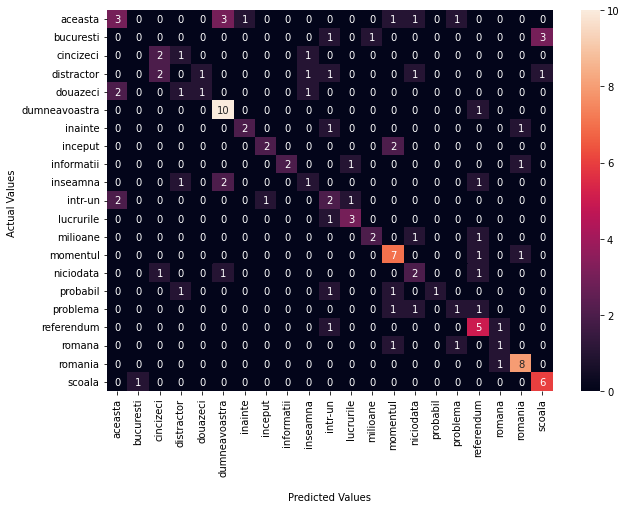

In [ ]:
test_acc_1, test_acc_5 = get_metrics_domain(params_domain_adaptation, 0, "DomainAdaptation", "best_model_domain_adaptation.pth")

## KD

Best model was saved at 152 epochs

Test
              precision    recall  f1-score   support

           0    0.20000   0.18182   0.19048        11
           1    0.00000   0.00000   0.00000         3
           2    0.00000   0.00000   0.00000         1
           3    0.28571   0.15385   0.20000        13
           4    0.00000   0.00000   0.00000         4
           5    0.45455   0.45455   0.45455        11
           6    0.25000   0.25000   0.25000         4
           7    0.25000   0.50000   0.33333         2
           8    0.75000   0.60000   0.66667         5
           9    0.00000   0.00000   0.00000         3
          10    0.16667   0.33333   0.22222         3
          11    0.50000   0.50000   0.50000         4
          12    0.00000   0.00000   0.00000         5
          13    0.55556   0.33333   0.41667        15
          14    0.40000   0.33333   0.36364         6
          15    0.00000   0.00000   0.00000         3
          16    0.50000   0.50000   0.50

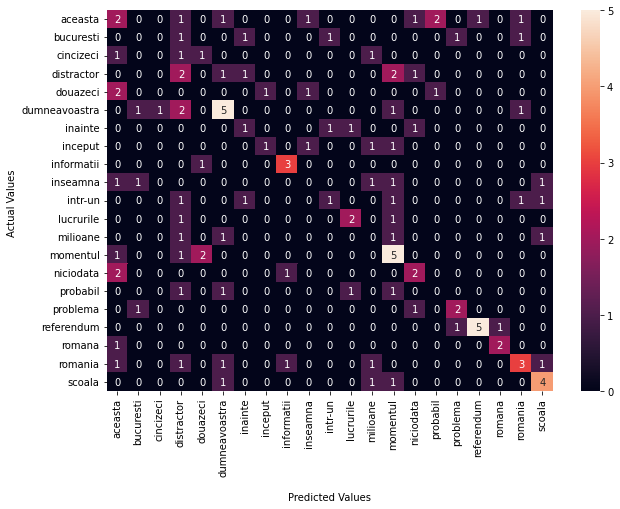

In [ ]:
test_acc_1, test_acc_5 = get_metrics(params_mobilenet_tcn, 0, "KD_simple_07_2", "best_model_mobilenet_tcn_07_2.pth")

Best model was saved at 194 epochs

Test


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    0.10000   0.07692   0.08696        13
           1    0.20000   0.25000   0.22222         4
           2    0.25000   0.33333   0.28571         3
           3    0.00000   0.00000   0.00000         8
           4    0.00000   0.00000   0.00000         4
           5    0.45455   0.50000   0.47619        10
           6    0.50000   0.50000   0.50000         4
           7    0.00000   0.00000   0.00000         3
           8    0.50000   0.66667   0.57143         3
           9    0.00000   0.00000   0.00000         2
          10    0.16667   0.16667   0.16667         6
          11    0.25000   0.33333   0.28571         3
          12    0.00000   0.00000   0.00000         0
          13    0.55556   0.41667   0.47619        12
          14    0.00000   0.00000   0.00000         5
          15    0.25000   0.33333   0.28571         3
          16    0.50000   0.22222   0.30769         9
          17    0.85714   0

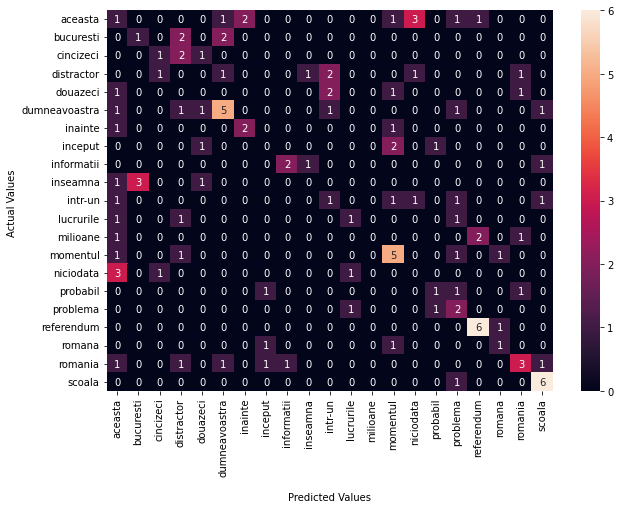

In [ ]:
test_acc_1, test_acc_5 = get_metrics(params_mobilenet_tcn, 6, "KD_simple_03_3", "best_model_mobilenet_tcn_03_3.pth")

Best model was saved at 148 epochs

Test
              precision    recall  f1-score   support

           0    0.10000   0.16667   0.12500         6
           1    0.00000   0.00000   0.00000         3
           2    0.50000   0.40000   0.44444         5
           3    0.00000   0.00000   0.00000         7
           4    0.00000   0.00000   0.00000         3
           5    0.45455   0.35714   0.40000        14
           6    0.25000   0.20000   0.22222         5
           7    0.25000   0.50000   0.33333         2
           8    0.50000   0.40000   0.44444         5
           9    0.20000   0.12500   0.15385         8
          10    0.00000   0.00000   0.00000         4
          11    0.25000   0.25000   0.25000         4
          12    0.50000   0.40000   0.44444         5
          13    0.66667   0.60000   0.63158        10
          14    0.20000   0.50000   0.28571         2
          15    0.25000   0.33333   0.28571         3
          16    0.25000   0.16667   0.20

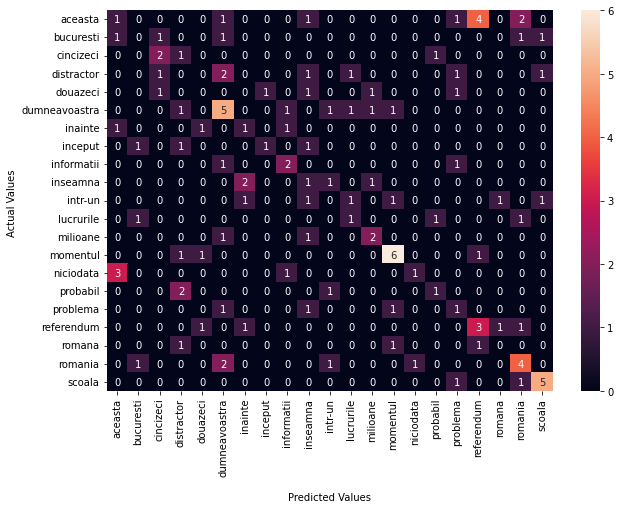

In [ ]:
test_acc_1, test_acc_5 = get_metrics(params_mobilenet_tcn, 8, "KD_simple_05", "best_model_mobilenet_tcn_05.pth")

Best model was saved at 188 epochs

Test
              precision    recall  f1-score   support

           0    0.20000   0.25000   0.22222         8
           1    0.20000   1.00000   0.33333         1
           2    0.00000   0.00000   0.00000         4
           3    0.14286   0.12500   0.13333         8
           4    0.00000   0.00000   0.00000         2
           5    0.45455   0.29412   0.35714        17
           6    0.50000   0.40000   0.44444         5
           7    0.00000   0.00000   0.00000         2
           8    0.25000   0.33333   0.28571         3
           9    0.00000   0.00000   0.00000         2
          10    0.16667   0.14286   0.15385         7
          11    0.50000   0.66667   0.57143         3
          12    0.00000   0.00000   0.00000         2
          13    0.44444   0.40000   0.42105        10
          14    0.40000   0.40000   0.40000         5
          15    0.25000   0.50000   0.33333         2
          16    0.25000   0.16667   0.20

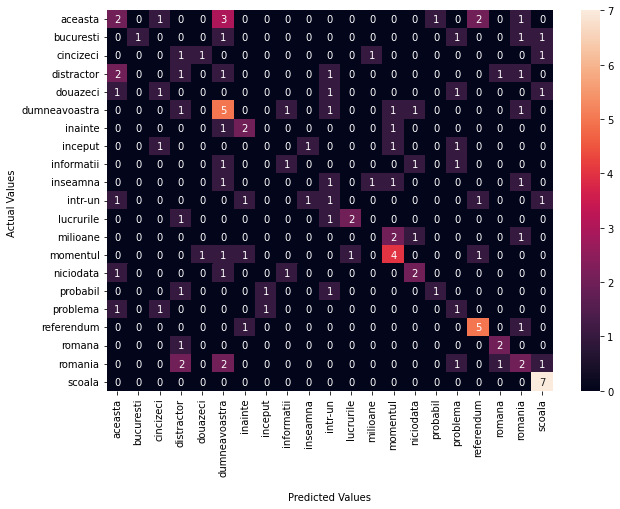

In [ ]:
test_acc_1, test_acc_5 = get_metrics(params_mobilenet_tcn, 0, "KD_simple_05_5", "best_model_mobilenet_tcn_05_5.pth")

Best model was saved at 197 epochs

Test
              precision    recall  f1-score   support

           0    0.30000   0.37500   0.33333         8
           1    0.20000   0.50000   0.28571         2
           2    0.25000   1.00000   0.40000         1
           3    0.14286   0.33333   0.20000         3
           4    0.20000   0.14286   0.16667         7
           5    0.63636   0.43750   0.51852        16
           6    0.00000   0.00000   0.00000         1
           7    0.00000   0.00000   0.00000         4
           8    0.50000   0.50000   0.50000         4
           9    0.20000   0.33333   0.25000         3
          10    0.33333   0.40000   0.36364         5
          11    0.25000   0.50000   0.33333         2
          12    0.00000   0.00000   0.00000         3
          13    0.33333   0.27273   0.30000        11
          14    0.20000   0.50000   0.28571         2
          15    0.25000   0.50000   0.33333         2
          16    0.25000   0.14286   0.18

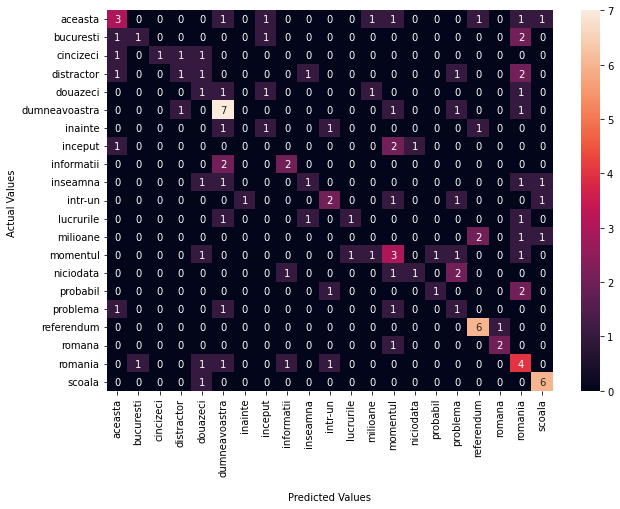

In [ ]:
test_acc_1, test_acc_5 = get_metrics(params_mobilenet_tcn, 1, "KD_simple_05_10", "best_model_mobilenet_tcn_05_10.pth")

Best model was saved at 147 epochs

Test
              precision    recall  f1-score   support

           0    0.40000   0.30769   0.34783        13
           1    0.00000   0.00000   0.00000         6
           2    0.25000   0.33333   0.28571         3
           3    0.00000   0.00000   0.00000         7
           4    0.00000   0.00000   0.00000         3
           5    0.63636   0.63636   0.63636        11
           6    0.00000   0.00000   0.00000         2
           7    0.00000   0.00000   0.00000         1
           8    0.50000   0.66667   0.57143         3
           9    0.20000   0.33333   0.25000         3
          10    0.33333   0.28571   0.30769         7
          11    0.00000   0.00000   0.00000         2
          12    0.00000   0.00000   0.00000         5
          13    0.66667   0.46154   0.54545        13
          14    0.20000   0.25000   0.22222         4
          15    0.25000   1.00000   0.40000         1
          16    0.25000   0.25000   0.25

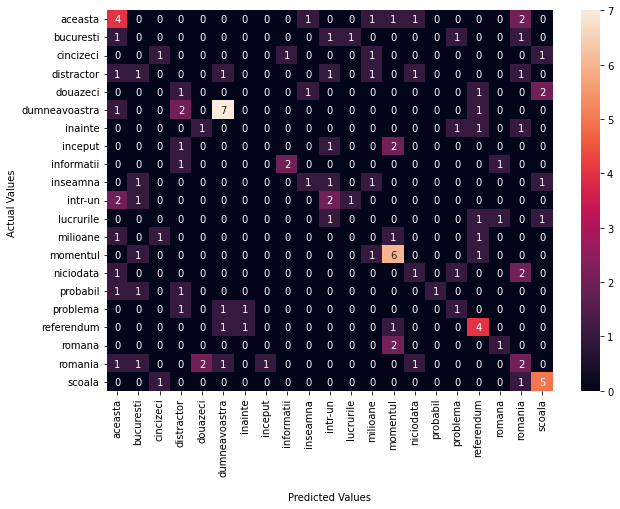

In [ ]:
test_acc_1, test_acc_5 = get_metrics(params_mobilenet_tcn, 3, "KD_simple_mixed_05first", "best_model_mobilenet_tcn_mixed_05first.pth")

Best model was saved at 163 epochs

Test
              precision    recall  f1-score   support

           0    0.70000   0.50000   0.58333        14
           1    0.40000   0.50000   0.44444         4
           2    0.00000   0.00000   0.00000         1
           3    0.28571   0.13333   0.18182        15
           4    0.00000   0.00000   0.00000         2
           5    0.36364   0.33333   0.34783        12
           6    0.25000   0.33333   0.28571         3
           7    0.00000   0.00000   0.00000         1
           8    0.25000   0.33333   0.28571         3
           9    0.00000   0.00000   0.00000         4
          10    0.00000   0.00000   0.00000         5
          11    0.25000   0.20000   0.22222         5
          12    0.00000   0.00000   0.00000         3
          13    0.22222   0.28571   0.25000         7
          14    0.20000   0.14286   0.16667         7
          15    0.00000   0.00000   0.00000         2
          16    0.25000   0.20000   0.22

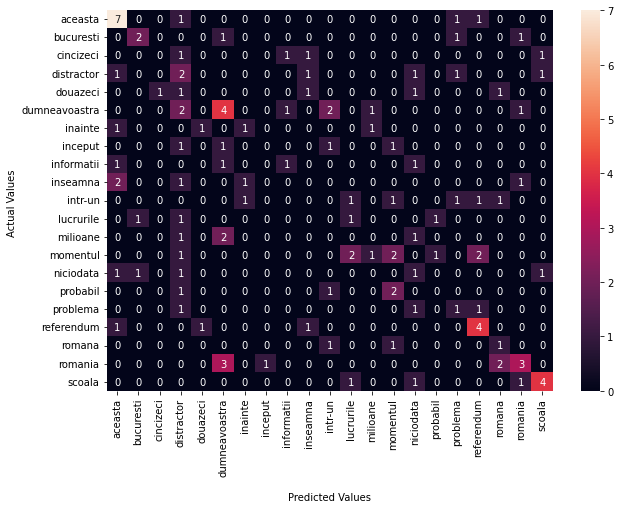

In [ ]:
test_acc_1, test_acc_5 = get_metrics(params_mobilenet_tcn, 3, "KD_simple_mixed_09first", "best_model_mobilenet_tcn_mixed_09first.pth")

Best model was saved at 276 epochs

Test
              precision    recall  f1-score   support

           0    0.50000   0.45455   0.47619        11
           1    0.20000   1.00000   0.33333         1
           2    0.25000   0.12500   0.16667         8
           3    0.14286   0.10000   0.11765        10
           4    0.00000   0.00000   0.00000         4
           5    0.81818   0.60000   0.69231        15
           6    0.50000   0.33333   0.40000         6
           7    0.00000   0.00000   0.00000         2
           8    0.25000   1.00000   0.40000         1
           9    0.00000   0.00000   0.00000         2
          10    0.50000   0.42857   0.46154         7
          11    0.50000   0.50000   0.50000         4
          12    0.00000   0.00000   0.00000         7
          13    0.44444   0.44444   0.44444         9
          14    0.20000   1.00000   0.33333         1
          15    0.25000   0.33333   0.28571         3
          16    0.25000   0.33333   0.28

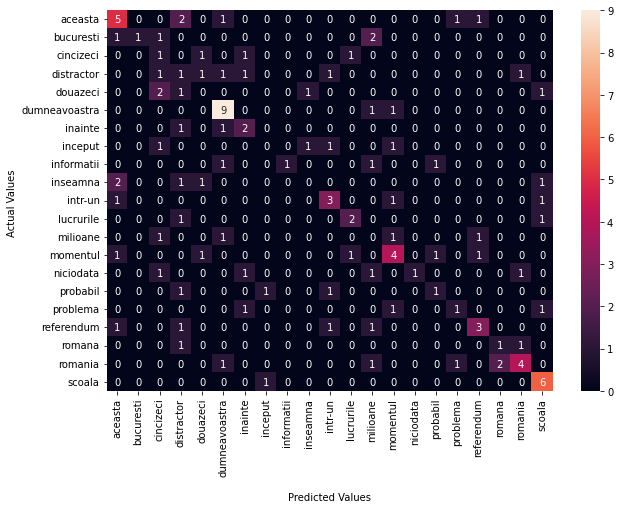

In [ ]:
test_acc_1, test_acc_5 = get_metrics(params_mobilenet_tcn, 5, "KD_gen1", "best_model_mobilenet_tcn_gen1.pth")

## Standard Models

Best model was saved at 50 epochs

Test
              precision    recall  f1-score   support

           0    0.20000   0.20000   0.20000        10
           1    0.50000   0.20000   0.28571         5
           2    0.20000   0.25000   0.22222         4
           3    0.00000   0.00000   0.00000         7
           4    0.25000   0.20000   0.22222         5
           5    0.40000   0.72727   0.51613        11
           6    0.60000   0.75000   0.66667         4
           7    0.40000   0.50000   0.44444         4
           8    0.66667   0.50000   0.57143         4
           9    0.00000   0.00000   0.00000         5
          10    0.66667   0.33333   0.44444         6
          11    0.40000   0.50000   0.44444         4
          12    0.00000   0.00000   0.00000         4
          13    0.41667   0.55556   0.47619         9
          14    0.20000   0.20000   0.20000         5
          15    1.00000   0.25000   0.40000         4
          16    0.20000   0.25000   0.222

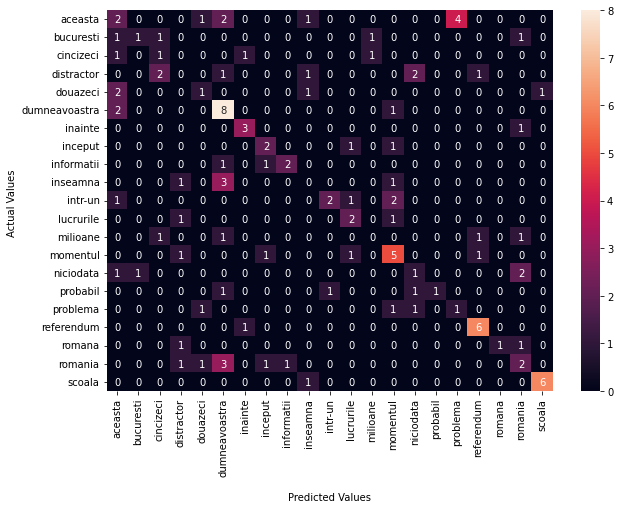

In [ ]:
test_acc_1, test_acc_5 = get_metrics(params_resnet_gru, 6, "ResnetGRU")

Best model was saved at 48 epochs

Test
              precision    recall  f1-score   support

           0    0.37500   0.30000   0.33333        10
           1    0.00000   0.00000   0.00000         5
           2    0.20000   0.25000   0.22222         4
           3    0.25000   0.14286   0.18182         7
           4    0.00000   0.00000   0.00000         5
           5    0.38095   0.72727   0.50000        11
           6    0.50000   0.50000   0.50000         4
           7    0.40000   0.50000   0.44444         4
           8    0.50000   0.50000   0.50000         4
           9    0.00000   0.00000   0.00000         5
          10    0.33333   0.16667   0.22222         6
          11    0.75000   0.75000   0.75000         4
          12    0.00000   0.00000   0.00000         4
          13    0.38462   0.55556   0.45455         9
          14    0.50000   0.20000   0.28571         5
          15    0.33333   0.25000   0.28571         4
          16    0.16667   0.25000   0.200

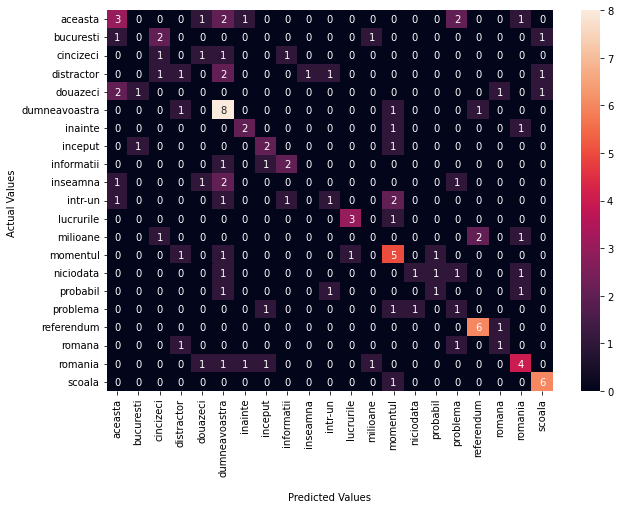

In [ ]:
test_acc_1, test_acc_5 = get_metrics(params_resnet_gru_nodropblock, 0, "ResnetGRU_nodrop")

[3072, 3072, 3072, 3072]
Best model was saved at 70 epochs

Test
              precision    recall  f1-score   support

           0    0.28571   0.20000   0.23529        10
           1    0.50000   0.20000   0.28571         5
           2    0.50000   0.25000   0.33333         4
           3    0.00000   0.00000   0.00000         7
           4    0.40000   0.40000   0.40000         5
           5    0.40000   0.54545   0.46154        11
           6    0.50000   0.50000   0.50000         4
           7    0.50000   0.25000   0.33333         4
           8    0.66667   0.50000   0.57143         4
           9    0.20000   0.20000   0.20000         5
          10    0.33333   0.16667   0.22222         6
          11    0.50000   0.25000   0.33333         4
          12    0.00000   0.00000   0.00000         4
          13    0.38462   0.55556   0.45455         9
          14    0.28571   0.40000   0.33333         5
          15    0.50000   0.25000   0.33333         4
          16    

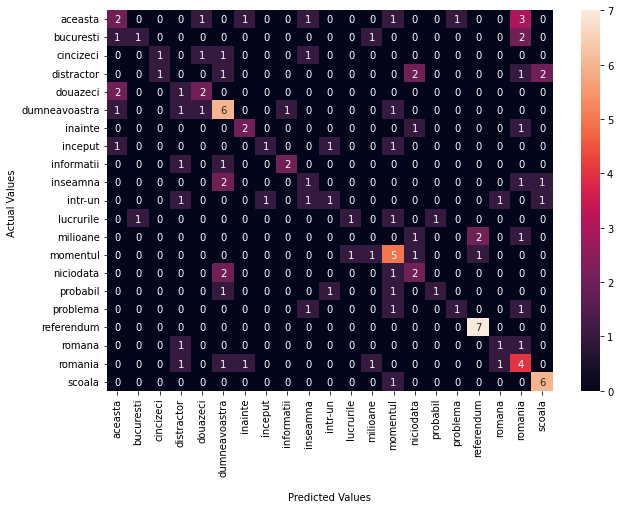

In [ ]:
test_acc_1, test_acc_5 = get_metrics(params_resnet_mstcn, 14, "ResnetMSTCN")

[3072, 3072, 3072, 3072]
Best model was saved at 55 epochs

Test
              precision    recall  f1-score   support

           0    0.40000   0.20000   0.26667        10
           1    0.20000   0.20000   0.20000         5
           2    0.40000   0.50000   0.44444         4
           3    0.00000   0.00000   0.00000         7
           4    0.00000   0.00000   0.00000         5
           5    0.38889   0.63636   0.48276        11
           6    0.66667   0.50000   0.57143         4
           7    0.66667   0.50000   0.57143         4
           8    1.00000   0.50000   0.66667         4
           9    0.00000   0.00000   0.00000         5
          10    0.14286   0.16667   0.15385         6
          11    0.66667   0.50000   0.57143         4
          12    0.00000   0.00000   0.00000         4
          13    0.46154   0.66667   0.54545         9
          14    0.28571   0.40000   0.33333         5
          15    0.00000   0.00000   0.00000         4
          16    

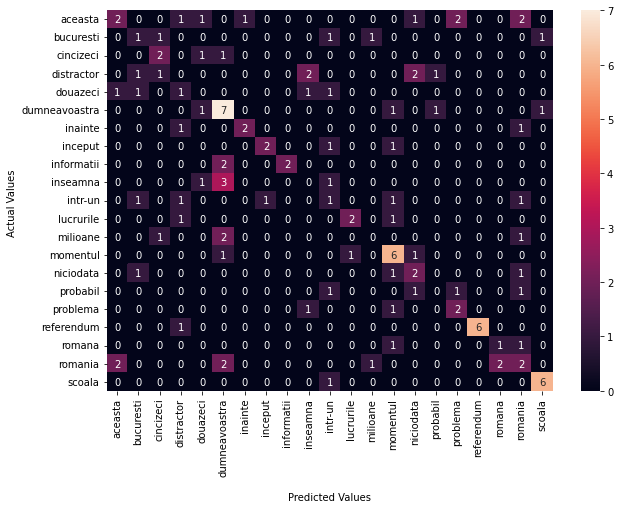

In [ ]:
test_acc_1, test_acc_5 = get_metrics(params_resnet_mstcn_nodropblock, 3, "ResnetMSTCN_nodrop")

In [ ]:
print(label_dict_wild)

{'aceasta': 0, 'bucuresti': 1, 'cincizeci': 2, 'distractor': 3, 'douazeci': 4, 'dumneavoastra': 5, 'inainte': 6, 'inceput': 7, 'informatii': 8, 'inseamna': 9, 'intr-un': 10, 'lucrurile': 11, 'milioane': 12, 'momentul': 13, 'niciodata': 14, 'probabil': 15, 'problema': 16, 'referendum': 17, 'romana': 18, 'romania': 19, 'scoala': 20}


## Load losses

In [ ]:
def load_loss(model_name):
  folder = os.path.join(mount_drive, my_drive, general_path, graphs_params_path, model_name)
  print(folder)
  train_loss = np.load(os.path.join(folder, "train_loss.npy"))
  test_loss = np.load(os.path.join(folder, "test_loss.npy"))
  return train_loss, test_loss

def load_accuracy(model_name):
  folder = os.path.join(mount_drive, my_drive, general_path, graphs_params_path, model_name)
  print(folder)
  train_acc = np.load(os.path.join(folder, "train_acc_1.npy"))
  test_acc = np.load(os.path.join(folder, "test_acc_1.npy"))
  return train_acc, test_acc

def plot_losses(train_loss, test_loss):
  plt.figure(figsize=(10, 7))
  plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
  plt.plot(test_loss, color='red', linestyle='-', label='val loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

def plot_accuracy(train_acc, test_acc):
  plt.figure(figsize=(10, 7))
  plt.plot(train_acc, color='orange', linestyle='-', label='train accuracy')
  plt.plot(test_acc, color='red', linestyle='-', label='val accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
train_tcn, test_tcn = load_loss("DomainAdaptation")
plot_losses(train_tcn, test_tcn)

train_acc, test_acc = load_accuracy("DomainAdaptation")
plot_accuracy(train_acc, test_acc)

# plt.figure(figsize=(10, 7))
# plt.plot(train_tcn, color='orange', linestyle='-', label='Train loss Resnet-MSTCN')
# plt.plot(test_tcn, color='red', linestyle='-', label='Val loss Resnet-MSTCN')
# plt.plot(train_gru, color='blue', linestyle='-', label='Train loss Resnet-GRU')
# plt.plot(test_gru, color='magenta', linestyle='-', label='Val loss Resnet-GRU')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.savefig(os.path.join(mount_drive, my_drive, general_path, graphs_params_path, "gru_mstcn.png"))

# Dataset Analysis

In [ ]:
def print_bar_plot(labels, title, x_label):
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(12,4))
    ax = sns.barplot(x=unique, y=counts)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Count")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
inv_map = {v: k for k, v in label_dict_wild.items()}
print(inv_map)

{0: 'aceasta', 1: 'bucuresti', 2: 'cincizeci', 3: 'distractor', 4: 'douazeci', 5: 'dumneavoastra', 6: 'inainte', 7: 'inceput', 8: 'informatii', 9: 'inseamna', 10: 'intr-un', 11: 'lucrurile', 12: 'milioane', 13: 'momentul', 14: 'niciodata', 15: 'probabil', 16: 'problema', 17: 'referendum', 18: 'romana', 19: 'romania', 20: 'scoala'}


In [ ]:
train_label_y = [inv_map[k] for k in train_set_y]
val_label_y = [inv_map[k] for k in val_set_y]
test_label_y = [inv_map[k] for k in test_set_y]

121


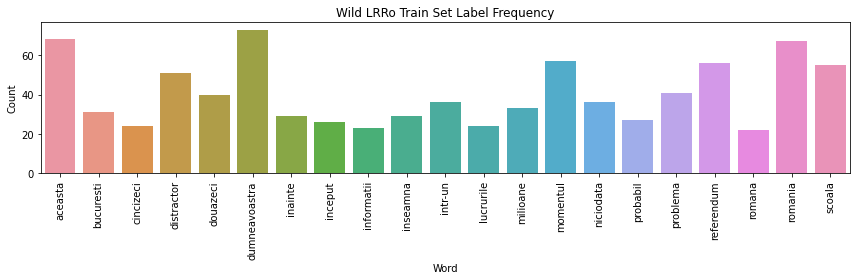

In [ ]:
print_bar_plot(train_label_y, "Wild LRRo Train Set Label Frequency", "Word")

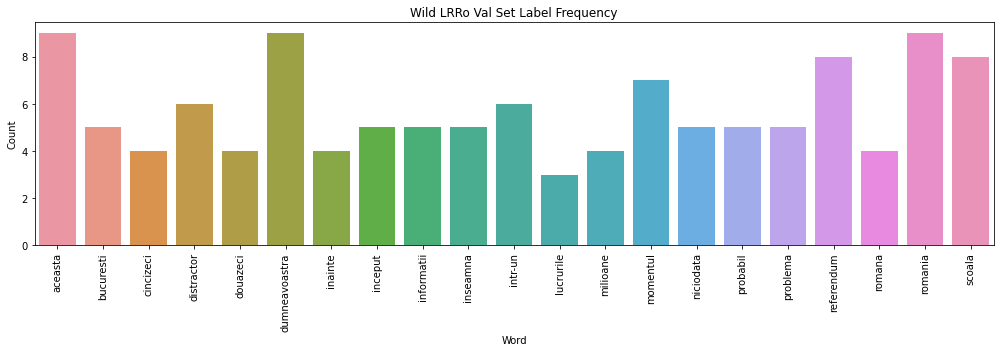

In [ ]:
print_bar_plot(val_label_y, "Wild LRRo Val Set Label Frequency", "Word")

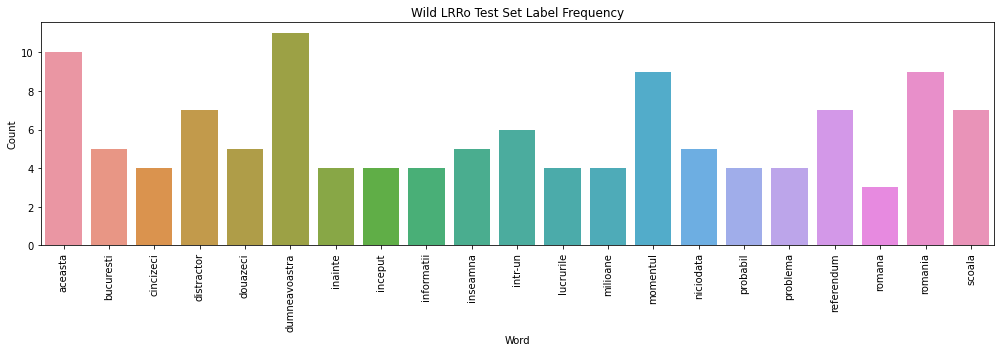

In [ ]:
print_bar_plot(test_label_y, "Wild LRRo Test Set Label Frequency", "Word")

# Domain Adaptation Visualization

In [ ]:
pip install torch_intermediate_layer_getter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torch-intermediate-layer-getter: filename=torch_intermediate_layer_getter-0.1.post1-py3-none-any.whl size=3726 sha256=bfe56182f3d8cf1f89150f6256c766ae58a5b110f831fbb9440cfefe730ea8da
  Stored in directory: /root/.cache/pip/wheels/59/53/37/8b81c4711686fbae03a35d8d1dac5edd9e4af9221fa8e17f6f
Successfully built torch-intermediate-layer-getter


In [ ]:
# Romanian Dataloader
train_dataset, val_dataset, test_dataset = create_datasets(train_set_x, train_set_y,
                                                          val_set_x, val_set_y,
                                                          test_set_x, test_set_y)
train_loader_ro, val_loader_ro, test_loader_ro = create_loaders(train_dataset, val_dataset, test_dataset, params["batch_size"], params["num_workers"])

# German Dataloader
train_dataset, val_dataset, test_dataset = create_glips_datasets(train_glips, val_glips, test_glips)
train_loader_de, val_loader_de, test_loader_de = create_glips_loaders(train_dataset, val_dataset, test_dataset, params["batch_size"], params["num_workers"])

In [ ]:
params = params_domain_adaptation

video_model, optim_video, scheduler, num_epochs = create_model_domain(params, domain_tcn_options, device)
model = load_model(video_model, "best_model_domain_adaptation.pth")
torch.manual_seed(0)
test_loss, test_acc_1, test_acc_5 = test_domain(model, test_loader_ro, test_loader_de,
                                          LSR(), nn.CrossEntropyLoss(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")
print()


[3072, 3072, 3072, 3072]
Best model was saved at 62 epochs

Test
Test loss: 3.712, test acc top-1: 50.41322, test acc top-5: 72.72727



In [ ]:
params = params_domain_adaptation

video_model, optim_video, scheduler, num_epochs = create_model_domain(params, domain_tcn_options, device)
model = load_model(video_model, "best_model_domain_adaptation.pth")

[3072, 3072, 3072, 3072]
Best model was saved at 62 epochs



In [ ]:
def get_outputs(model, loader, device):
  cat_tensor = torch.empty(0, 29, 512).to(device)
  with torch.no_grad():
    for i, data in enumerate(loader):
      video, label = data
      video = video.to(device)

      # forward pass
      f_v = model.video_cnn(video)
      f_v = model.dropout(f_v)
      f_v = f_v.float()
      #print(f_v.shape)
      cat_tensor = torch.cat((cat_tensor, f_v))
      del f_v
  return cat_tensor

In [ ]:
def get_outputs_de(model, loader, device):
  cat_tensor = torch.empty(0, 29, 512).to(device)
  with torch.no_grad():
    for i, data in enumerate(loader):
      video = data
      video = video.to(device)

      # forward pass
      f_v = model.video_cnn(video)
      f_v = model.dropout(f_v)
      f_v = f_v.float()
      #print(f_v.shape)
      cat_tensor = torch.cat((cat_tensor, f_v))
      del f_v
  return cat_tensor

In [ ]:
cat_tensor_ro = get_outputs(model, train_loader_ro, device)
print(cat_tensor_ro.shape)

torch.Size([848, 29, 512])


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
tensor_ro = cat_tensor_ro.mean(1)
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z_ro = tsne.fit_transform(tensor_ro.cpu().numpy())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 848 samples in 0.001s...
[t-SNE] Computed neighbors for 848 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 848 / 848
[t-SNE] Mean sigma: 4.589600
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.791290
[t-SNE] KL divergence after 1000 iterations: 1.407084


In [ ]:
cat_tensor_de = get_outputs_de(model, train_loader_de, device)
print(cat_tensor_de.shape)

torch.Size([848, 29, 512])


In [ ]:
tensor_de = cat_tensor_de.mean(1)
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z_de = tsne.fit_transform(tensor_de.cpu().numpy())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 848 samples in 0.001s...
[t-SNE] Computed neighbors for 848 samples in 0.074s...
[t-SNE] Computed conditional probabilities for sample 848 / 848
[t-SNE] Mean sigma: 3.275294
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.646835
[t-SNE] KL divergence after 1000 iterations: 1.777889


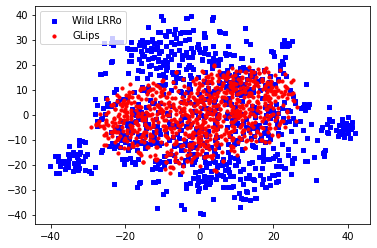

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(z_ro[:, 0], z_ro[:, 1], s=10, c='b', marker="s", label='Wild LRRo')
ax1.scatter(z_de[:, 0], z_de[:, 1], s=10, c='r', marker="o", label='GLips')
plt.legend(loc='upper left');
plt.show()

In [ ]:
concat_tensor = torch.cat((tensor_ro, tensor_de))
print(concat_tensor.shape)
y = np.empty(concat_tensor.shape[0], dtype=object)
first_dataset_shape = tensor_ro.shape[0]
y[:first_dataset_shape] = "Wild LRRo"
y[first_dataset_shape: ] = "GLips"

torch.Size([1696, 512])


In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(concat_tensor.cpu().numpy())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1696 samples in 0.001s...
[t-SNE] Computed neighbors for 1696 samples in 0.202s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1696
[t-SNE] Computed conditional probabilities for sample 1696 / 1696
[t-SNE] Mean sigma: 3.495648
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.349464
[t-SNE] KL divergence after 1000 iterations: 1.989279


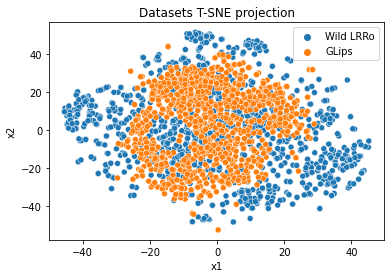

In [ ]:
df = pd.DataFrame()
df["y"] = y
df["x1"] = z[:,0]
df["x2"] = z[:,1]

sns.scatterplot(x="x1", y="x2", hue=df.y.tolist(),
                data=df).set(title="Datasets T-SNE projection")
plt.savefig("dataset_viz.png")

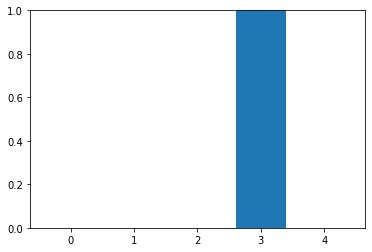

In [ ]:
arr1 = np.array([0, 0, 0, 1, 0])
arr2 = np.array([0.05, 0.05, 0.05, 0.8, 0.05]);

ax = plt.gca()
ax.set_ylim([0, 1])
plt.bar(np.arange(len(arr1)), arr1)
plt.show()

<BarContainer object of 5 artists>

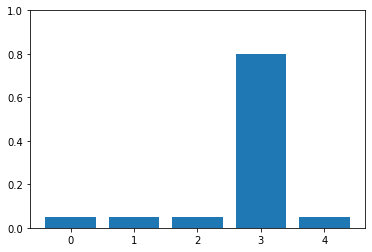

In [ ]:
ax = plt.gca()

ax.set_ylim([0, 1])
plt.bar(np.arange(len(arr2)), arr2)

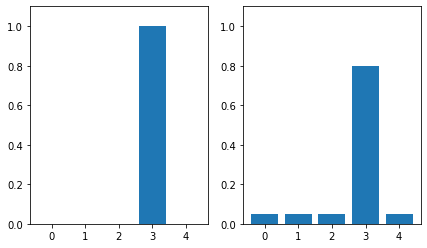

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.set_ylim([0, 1.1])
ax1.bar(np.arange(len(arr1)), arr1)
ax1.set_xticks(np.arange(0, 5))
ax2.set_ylim([0, 1.1])
ax2.bar(np.arange(len(arr2)), arr2)
ax2.set_xticks(np.arange(0, 5))
plt.savefig("labelsmooth.png")

# Testing with Lateral Inhibition

## Prerequisites

In [ ]:
def create_model_li(params, device):
  video_model = VideoModel(params["num_classes"],
                           drop_prob=params["drop_prob"],
                           se=params["se"],
                           use_dropblock=params["use_dropblock"],
                           separable_conv=params["separable_conv"],
                           use_tcn=params["use_tcn"],
                           tcn_options=params["tcn_options"],
                           backbone_type=params["backbone_type"],
                           use_li=params["use_li"])

  optim_video, scheduler = create_optim_scheduler(video_model, params["lr"], params["num_epochs"], params["use_adam"])

  if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    video_model = nn.DataParallel(video_model)

  video_model = video_model.to(device)
  return video_model, optim_video, scheduler, params["num_epochs"]

In [ ]:
def train_model_li(model, optim_video, scheduler,
                train_loader,
                val_loader,
                num_epochs, mixup, model_filename):
  train_loss, val_loss = [], []
  train_acc_1, train_acc_5, val_acc_1, val_acc_5 = [], [], [], []

  criterion = LSR()
  save_best_model = SaveBestModelAcc(model_filename)
  with torch.no_grad():
      torch.cuda.empty_cache()

  for epoch in range(num_epochs):
    print(f"[INFO]: Epoch {epoch + 1} of {num_epochs}")
    train_epoch_loss, train_epoch_acc_1, train_epoch_acc_5 = train(model, train_loader,
                                              optim_video, scheduler, criterion, device, mixup)
    val_epoch_loss, val_epoch_acc_1, val_epoch_acc_5 = test(model, val_loader,
                                                  criterion, device)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

    train_acc_1.append(train_epoch_acc_1)
    train_acc_5.append(train_epoch_acc_5)

    val_acc_1.append(val_epoch_acc_1)
    val_acc_5.append(val_epoch_acc_5)

    print(f"Training loss: {train_epoch_loss:.3f}, training acc top-1: {train_epoch_acc_1:.5f}, training acc top-5: {train_epoch_acc_5:.5f}")
    print(f"Val loss: {val_epoch_loss:.3f}, val acc top-1: {val_epoch_acc_1:.5f}, val acc top-5: {val_epoch_acc_5:.5f}")

    # save the best model till now if we have the least loss in the current epoch
    save_best_model(val_epoch_acc_1, epoch, model, optim_video)
    print('-'*50)

  print("TRAINING COMPLETE")

  return train_acc_1, train_acc_5, val_acc_1, val_acc_5, train_loss, val_loss

## ResNet + MSTCN + LI

In [ ]:
params = params_resnet_mstcn_li
video_model, optim_video, scheduler, num_epochs = create_model_li(params, device)

In [ ]:
#summary(video_model, input_size=(29, 1, 88, 88))

In [ ]:
train_dataset, val_dataset, test_dataset = create_datasets(
                                                train_set_x, train_set_y,
                                                val_set_x, val_set_y,
                                                test_set_x, test_set_y)
train_loader, val_loader, test_loader = create_loaders(train_dataset, val_dataset, test_dataset, 8, params["num_workers"])

In [ ]:
print(params["model_filename"])
torch.cuda.empty_cache()

best_model_resnet18_mstcn_li.pth


In [ ]:
train_acc_1, train_acc_5,\
val_acc_1, val_acc_5,\
train_loss, val_loss = train_model_li(video_model, optim_video, scheduler,
                                              train_loader,
                                              val_loader,
                                              num_epochs, params["mixup"], params["model_filename"])

[INFO]: Epoch 1 of 80
Training
Test
Training loss: 3.849, training acc top-1: 6.36792, training acc top-5: 31.13208
Val loss: 3.121, val acc top-1: 9.16667, val acc top-5: 34.16667

Best val acc: 9.166666666666666

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 80
Training
Test
Training loss: 3.062, training acc top-1: 10.61321, training acc top-5: 33.84434
Val loss: 3.050, val acc top-1: 4.16667, val acc top-5: 32.50000
--------------------------------------------------
[INFO]: Epoch 3 of 80
Training
Test
Training loss: 3.009, training acc top-1: 8.84434, training acc top-5: 36.91038
Val loss: 3.057, val acc top-1: 7.50000, val acc top-5: 30.83333
--------------------------------------------------
[INFO]: Epoch 4 of 80
Training
Test
Training loss: 2.997, training acc top-1: 9.90566, training acc top-5: 38.91509
Val loss: 3.141, val acc top-1: 5.00000, val acc top-5: 32.50000
--------------------------------------------------
[INFO

In [ ]:
# evaluate the best model on the test set
print()
print("Evaluation on test set...")
model = load_model(video_model, params["model_filename"])
torch.manual_seed(6)
test_loss, test_acc_1, test_acc_5 = test(model, test_loader,
                                          LSR(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")
print()


Evaluation on test set...
Best model was saved at 80 epochs

Test
Test loss: 2.341, test acc top-1: 42.97521, test acc top-5: 70.24793



## ResNet + GRU + LI

In [ ]:
params = params_resnet_gru_li
video_model, optim_video, scheduler, num_epochs = create_model_li(params, device)

In [ ]:
summary(video_model, input_size=(29, 1, 88, 88))

In [ ]:
train_dataset, val_dataset, test_dataset = create_datasets(
                                                train_set_x, train_set_y,
                                                val_set_x, val_set_y,
                                                test_set_x, test_set_y)
train_loader, val_loader, test_loader = create_loaders(train_dataset, val_dataset, test_dataset, 8, params["num_workers"])

In [ ]:
print(params["model_filename"])

best_model_resnet18_gru_li.pth


In [ ]:
train_acc_1, train_acc_5,\
val_acc_1, val_acc_5,\
train_loss, val_loss = train_model_li(video_model, optim_video, scheduler,
                                              train_loader,
                                              val_loader,
                                              num_epochs, params["mixup"], params["model_filename"])

[INFO]: Epoch 1 of 80
Training
Test
Training loss: 3.096, training acc top-1: 8.60849, training acc top-5: 32.66509
Val loss: 3.104, val acc top-1: 5.00000, val acc top-5: 30.83333

Best val acc: 5.0

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 80
Training
Test
Training loss: 3.022, training acc top-1: 8.25472, training acc top-5: 35.14151
Val loss: 3.145, val acc top-1: 3.33333, val acc top-5: 30.83333
--------------------------------------------------
[INFO]: Epoch 3 of 80
Training
Test
Training loss: 3.008, training acc top-1: 7.66509, training acc top-5: 37.14623
Val loss: 3.112, val acc top-1: 5.83333, val acc top-5: 30.00000

Best val acc: 5.833333333333333

Saving best model for epoch: 3

--------------------------------------------------
[INFO]: Epoch 4 of 80
Training
Test
Training loss: 3.000, training acc top-1: 8.84434, training acc top-5: 36.79245
Val loss: 3.097, val acc top-1: 8.33333, val acc top-5: 34.16667

Best

In [ ]:
# evaluate the best model on the test set
print()
print("Evaluation on test set...")
model = load_model(video_model, params["model_filename"])
torch.manual_seed(1)
test_loss, test_acc_1, test_acc_5 = test(model, test_loader,
                                          LSR(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")
print()


Evaluation on test set...
Best model was saved at 52 epochs

Test
Test loss: 2.118, test acc top-1: 47.10744, test acc top-5: 76.03306



## Domain Adaptation

### MSTCN + GLips

In [ ]:
params = params_domain_adaptation_li

In [ ]:
adversarial_model, optim_video, scheduler, num_epochs = create_model_domain_li(params, domain_tcn_options, device)

In [ ]:
summary(adversarial_model, input_size=(29, 1, 88, 88))

In [ ]:
print(params["model_filename"])

best_model_domain_adaptation_li.pth


In [ ]:
train_acc_1, train_acc_5,\
val_acc_1, val_acc_5,\
train_loss, val_loss = train_model_domain(adversarial_model, optim_video, scheduler,
                                          train_loader_ro, val_loader_ro,
                                          train_loader_de, val_loader_de,
                                          params["num_epochs"], params["mixup"], params["model_filename"])

In [ ]:
# evaluate the best model on the test set
print()
print("Evaluation on test set...")
model = load_model(adversarial_model, params["model_filename"])
torch.manual_seed(5)
test_loss, test_acc_1, test_acc_5 = test_domain(model, test_loader_ro, test_loader_de,
                                          LSR(), nn.CrossEntropyLoss(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")
print()

### GRU + GLips

In [ ]:
params = params_domain_adaptation_gru_li

In [ ]:
adversarial_model, optim_video, scheduler, num_epochs = create_model_domain_li(params, domain_tcn_options, device)

In [ ]:
summary(adversarial_model, input_size=(29, 1, 88, 88))

In [ ]:
print(params["model_filename"])

best_model_domain_adaptation_gru_li.pth


In [ ]:
train_acc_1, train_acc_5,\
val_acc_1, val_acc_5,\
train_loss, val_loss = train_model_domain(adversarial_model, optim_video, scheduler,
                                          train_loader_ro, val_loader_ro,
                                          train_loader_de, val_loader_de,
                                          params["num_epochs"], params["mixup"], params["model_filename"])

In [ ]:
# evaluate the best model on the test set
print()
print("Evaluation on test set...")
torch.manual_seed(12)
model = load_model(adversarial_model, params["model_filename"])
test_loss, test_acc_1, test_acc_5 = test_domain(model, test_loader_ro, test_loader_de,
                                          LSR(), nn.CrossEntropyLoss(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")
print()


Evaluation on test set...
Best model was saved at 71 epochs

Test
Test loss: 3.748, test acc top-1: 50.41322, test acc top-5: 73.55372



## Domain Adaptation + GRU

In [ ]:
params = params_domain_adaptation_gru

In [ ]:
adversarial_model, optim_video, scheduler, num_epochs = create_model_domain(params, domain_tcn_options, device)

In [ ]:
summary(adversarial_model, input_size=(29, 1, 88, 88))

In [ ]:
print(params["model_filename"])

best_model_domain_adaptation_gru.pth


In [ ]:
train_acc_1, train_acc_5,\
val_acc_1, val_acc_5,\
train_loss, val_loss = train_model_domain(adversarial_model, optim_video, scheduler,
                                          train_loader_ro, val_loader_ro,
                                          train_loader_de, val_loader_de,
                                          params["num_epochs"], params["mixup"], params["model_filename"])

In [ ]:
# evaluate the best model on the test set
print()
print("Evaluation on test set...")
model = load_model(adversarial_model, params["model_filename"])
torch.manual_seed(3)
test_loss, test_acc_1, test_acc_5 = test_domain(model, test_loader_ro, test_loader_de,
                                          LSR(), nn.CrossEntropyLoss(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")
print()


Evaluation on test set...
Best model was saved at 43 epochs

Test
Test loss: 3.456, test acc top-1: 52.06612, test acc top-5: 84.29752



# Multilingual domain adaptation

## Train and test functions

In [ ]:
def train_domain_adaptation_ml(model, epoch, n_epochs, trainloader_source, trainloader_target, optimizer, scheduler, criterion, domain_criterion, device, mixup):
    train_running_loss = 0.0
    train_running_correct_1, train_running_correct_5 = 0, 0
    counter = 0

    len_dataloader = min(len(trainloader_source), len(trainloader_target))
    data_source_iter = iter(trainloader_source)
    data_target_iter = iter(trainloader_target)

    print("Training")
    model.train()

    i = 0
    while i < len_dataloader:
      counter += 1
      p = float(i + epoch * len_dataloader) / n_epochs / len_dataloader
      grl_lambda = 2. / (1. + np.exp(-10 * p)) - 1
      grl_lambda = torch.tensor(grl_lambda)

      # Source Dataset
      data_source = data_source_iter.next()
      video_source, label_source = data_source
      video_source = video_source.to(device)
      label_source = label_source.to(device)
      domain_label = torch.zeros(video_source.shape[0], dtype=torch.long).to(device)

      optimizer.zero_grad(set_to_none = True)

      # mixing videos in batch for data augmentation + forward pass
      if mixup:
          lambda_ = np.random.beta(alpha, alpha)
          index = torch.randperm(video_source.size(0))

          mix_video = lambda_ * video_source + (1 - lambda_) * video_source[index, :]
          label_a, label_b = label_source, label_source[index]
          label_domain_a, label_domain_b = domain_label, domain_label[index]

          y_v, domain_pred = model(mix_video, grl_lambda)
          del mix_video

          # also mix losses
          loss_source_word = lambda_ * criterion(y_v, label_a) + (1 - lambda_) * criterion(y_v, label_b)
          loss_source_domain = lambda_ * domain_criterion(domain_pred, label_domain_a) + (1 - lambda_) * domain_criterion(domain_pred, label_domain_b)
      else:
          # simple forward pass
          y_v, domain_pred = model(video_source, grl_lambda)
          loss_source_word = criterion(y_v, label_source)
          loss_source_domain = domain_criterion(domain_pred, domain_label)

      del data_source, video_source, domain_label, domain_pred

      # Target Dataset
      data_target, domain_label_target = data_target_iter.next()
      video_target = data_target
      video_target = video_target.to(device)
      domain_label_target = domain_label_target.to(device)

      _, domain_pred_target = model(video_target, grl_lambda)
      loss_target_domain = domain_criterion(domain_pred_target, domain_label_target)

      loss = loss_source_word + loss_source_domain + loss_target_domain

      # compute loss
      train_running_loss += loss.detach().item()

      # compute top-1 and top-5 correct predictions from the softmax scores
      correct1, correct5 = correct_predictions_topk(y_v, label_source, topk=(1, 5))
      train_running_correct_1 += correct1.item()
      train_running_correct_5 += correct5.item()

      del data_target, video_target, correct1, correct5, domain_pred_target, domain_label_target, y_v
      del label_source

      # backpropagation
      loss.backward()
      del loss

      # update the optimizer parameters
      optimizer.step()
      i += 1

    # update learning rate with scheduler (cosine scheduling)
    scheduler.step()

    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc_1 = 100. * (train_running_correct_1 / len(trainloader_source.dataset))
    epoch_acc_5 = 100. * (train_running_correct_5 / len(trainloader_source.dataset))
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def train_model_domain_ml(model, optim_video, scheduler,
                       train_loader_source, val_loader_source,
                       train_loader_target, val_loader_target,
                       num_epochs, mixup, model_filename):
  train_loss, val_loss = [], []
  train_acc_1, train_acc_5, val_acc_1, val_acc_5 = [], [], [], []

  criterion = LSR()
  domain_criterion = nn.CrossEntropyLoss()
  save_best_model = SaveBestModelAcc(model_filename)
  with torch.no_grad():
      torch.cuda.empty_cache()

  for epoch in range(num_epochs):
    print(f"[INFO]: Epoch {epoch + 1} of {num_epochs}")
    train_epoch_loss, train_epoch_acc_1, train_epoch_acc_5 = train_domain_adaptation_ml(model, epoch, num_epochs,
                                              train_loader_source, train_loader_target,
                                              optim_video, scheduler,
                                              criterion, domain_criterion,
                                              device, mixup)

    val_epoch_loss, val_epoch_acc_1, val_epoch_acc_5 = test_domain_ml(model, val_loader_source, val_loader_target,
                                                  criterion, domain_criterion, device)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

    train_acc_1.append(train_epoch_acc_1)
    train_acc_5.append(train_epoch_acc_5)

    val_acc_1.append(val_epoch_acc_1)
    val_acc_5.append(val_epoch_acc_5)

    print(f"Training loss: {train_epoch_loss:.3f}, training acc top-1: {train_epoch_acc_1:.5f}, training acc top-5: {train_epoch_acc_5:.5f}")
    print(f"Val loss: {val_epoch_loss:.3f}, val acc top-1: {val_epoch_acc_1:.5f}, val acc top-5: {val_epoch_acc_5:.5f}")

    # save the best model till now if we have the least loss in the current epoch
    save_best_model(val_epoch_acc_1, epoch, model, optim_video)
    print('-'*50)
    torch.cuda.empty_cache()

  print("TRAINING COMPLETE")

  return train_acc_1, train_acc_5, val_acc_1, val_acc_5, train_loss, val_loss

In [ ]:
def test_domain_ml(model, testloader_source, testloader_target, criterion, domain_criterion, device):
    test_running_loss = 0.0
    test_running_correct_1 = 0
    test_running_correct_5 = 0
    counter = 0

    len_dataloader = min(len(testloader_source), len(testloader_target))
    data_source_iter = iter(testloader_source)
    data_target_iter = iter(testloader_target)

    print("Test")
    model.eval()
    with torch.no_grad():
      i = 0
      while i < len_dataloader:
        counter += 1

        # source dataset
        data_source = data_source_iter.next()
        video_source, label_source = data_source
        video_source = video_source.to(device)
        label_source = label_source.to(device)
        domain_label = torch.zeros(video_source.shape[0], dtype=torch.long).to(device)

        y_v, domain_pred = model(video_source, 0)
        loss_source = criterion(y_v, label_source)
        loss_source_domain = domain_criterion(domain_pred, domain_label)

        # # target dataset
        # data_target, domain_label_target = data_target_iter.next()
        # print(domain_label_target)
        # video_target = data_target
        # video_target = video_target.to(device)
        # domain_label_target = domain_label_target.to(device)

        # _, domain_pred_target = model(video_target, 0)
        # loss_target_domain = domain_criterion(domain_pred_target, domain_label_target)

        loss = loss_source + loss_source_domain

        # compute loss
        test_running_loss += loss.detach().item()

        # compute top-1 and top-5 correct predictions from the softmax scores
        correct1, correct5 = correct_predictions_topk(y_v, label_source, topk=(1, 5))
        test_running_correct_1 += correct1.item()
        test_running_correct_5 += correct5.item()

        del data_source, video_source, y_v, loss, correct1, correct5
        i += 1

    # loss and accuracy for the complete epoch
    epoch_loss = test_running_loss / counter
    epoch_acc_1 = 100. * (test_running_correct_1 / len(testloader_source.dataset))
    epoch_acc_5 = 100. * (test_running_correct_5 / len(testloader_source.dataset))
    return epoch_loss, epoch_acc_1, epoch_acc_5

## Execution

In [ ]:
params = params_multilingual_gru

In [ ]:
adversarial_model, optim_video, scheduler, num_epochs = create_model_domain_multilingual(params, domain_tcn_options, device)

In [ ]:
# model summary
summary(adversarial_model, input_size=(29, 1, 88, 88))

In [ ]:
print(params["model_filename"])

best_multilingual_gru.pth


In [ ]:
train_acc_1, train_acc_5,\
val_acc_1, val_acc_5,\
train_loss, val_loss = train_model_domain_ml(adversarial_model, optim_video, scheduler,
                                          train_loader_ro, val_loader_ro,
                                          train_loader_ml, val_loader_ml,
                                          params["num_epochs"], params["mixup"], params["model_filename"])

In [ ]:
# evaluate the best model on the test set
print()
print("Evaluation on test set...")
#model = load_model(adversarial_model, params["model_filename"])
torch.manual_seed(1)
test_loss, test_acc_1, test_acc_5 = test_domain_ml(model, test_loader_ro, test_loader_ml,
                                          LSR(), nn.CrossEntropyLoss(), device)
print(f"Test loss: {test_loss:.3f}, test acc top-1: {test_acc_1:.5f}, test acc top-5: {test_acc_5:.5f}")
print()


Evaluation on test set...
Test
Test loss: 2.430, test acc top-1: 57.02479, test acc top-5: 80.99174

